# Coca-Cola (KO) stock trading


In [1]:
import numpy as np
from numpy.random import seed
seed(1)

# financial libs
!pip install yfinance
import yfinance as yf
from ta import add_all_ta_features # technical analysis

#plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

You should consider upgrading via the '/Users/dmitry.volkov/.pyenv/versions/3.8.6/bin/python3.8 -m pip install --upgrade pip' command.


# 1. General EDA & Data preprocessing

## 1.1 Downloading data from Yahoo Finance

In [2]:
ticker = 'KO'
start = '2010-01-04'
end = '2021-08-13'
df = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  28.580000  28.610001  28.450001  28.520000  19.798510  13870400
2010-01-05  28.424999  28.495001  28.070000  28.174999  19.559002  23172400
2010-01-06  28.174999  28.219999  27.990000  28.165001  19.552065  19264600
2010-01-07  28.165001  28.184999  27.875000  28.094999  19.503473  13234600
2010-01-08  27.730000  27.820000  27.375000  27.575001  19.142490  28712400

## 1.2 Prices & Volume Chart
Let's start with drawing close prices chart to get a sense of historical prices. Below prices presented a Volume chart which shows daily stock turnover.

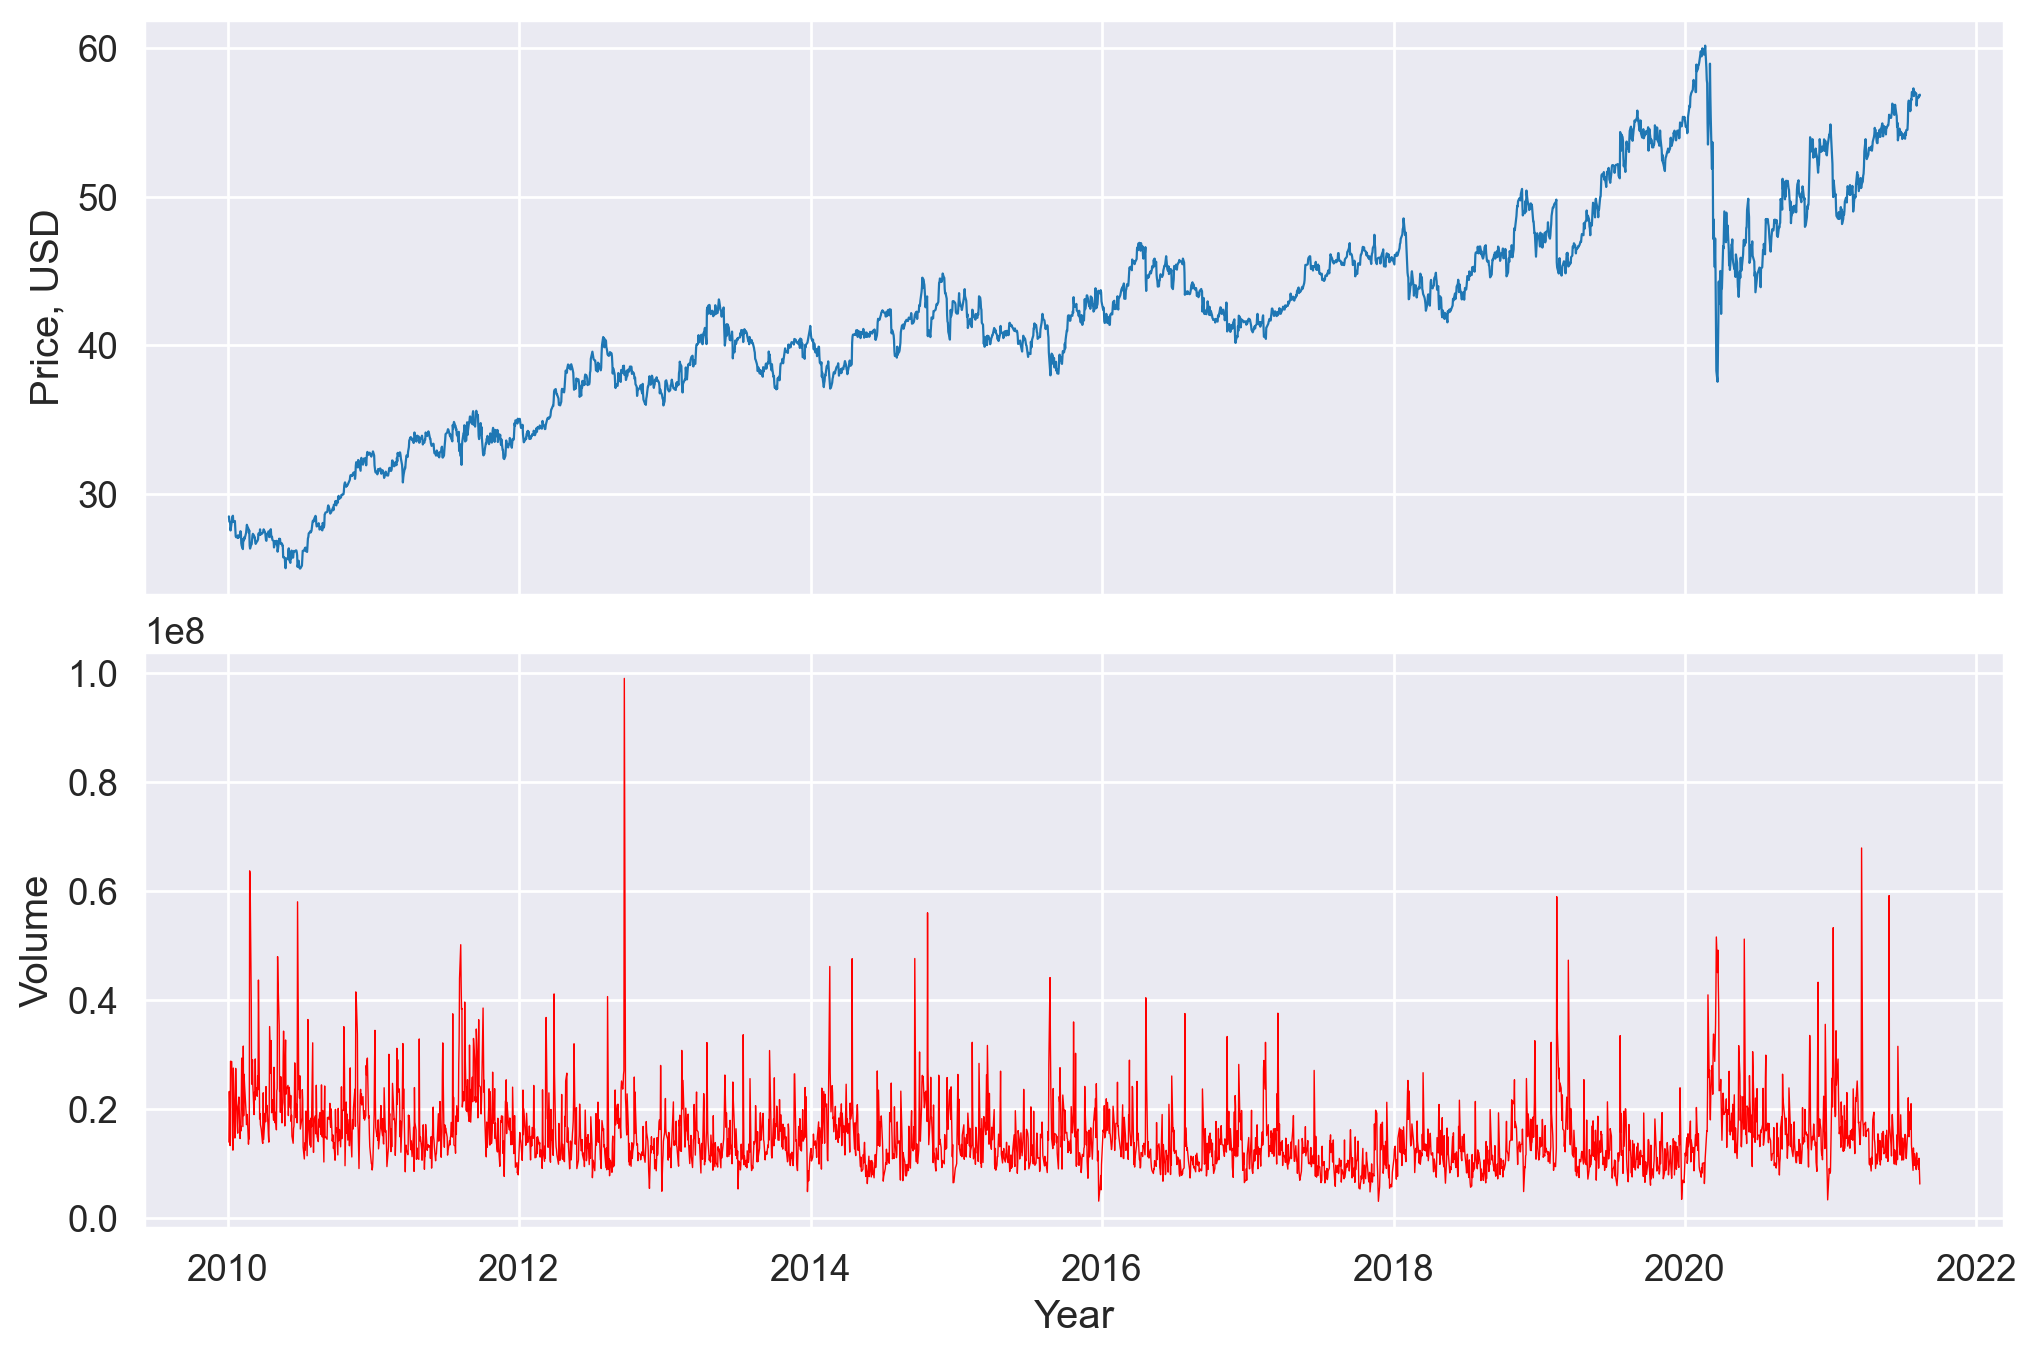

In [4]:
fig, axs = plt.subplots(ncols=1, nrows = 2, figsize=(12,8), sharex=True, dpi=200)
fig.subplots_adjust(hspace=0.1)
sns.lineplot(x = df.index, y=df['Close'], ax=axs[0], linewidth=.8)
axs[0].set_ylabel('Price, USD')
sns.lineplot(x=df.index, y=df['Volume'], color='r', ax=axs[1], linewidth=.5)
axs[1].set_xlabel('Year')
plt.show()

## 1.3 Distribution of daily return 

Calculate return as a percentage change between current and next day.

In [5]:
df['return'] = df['Close'].pct_change()

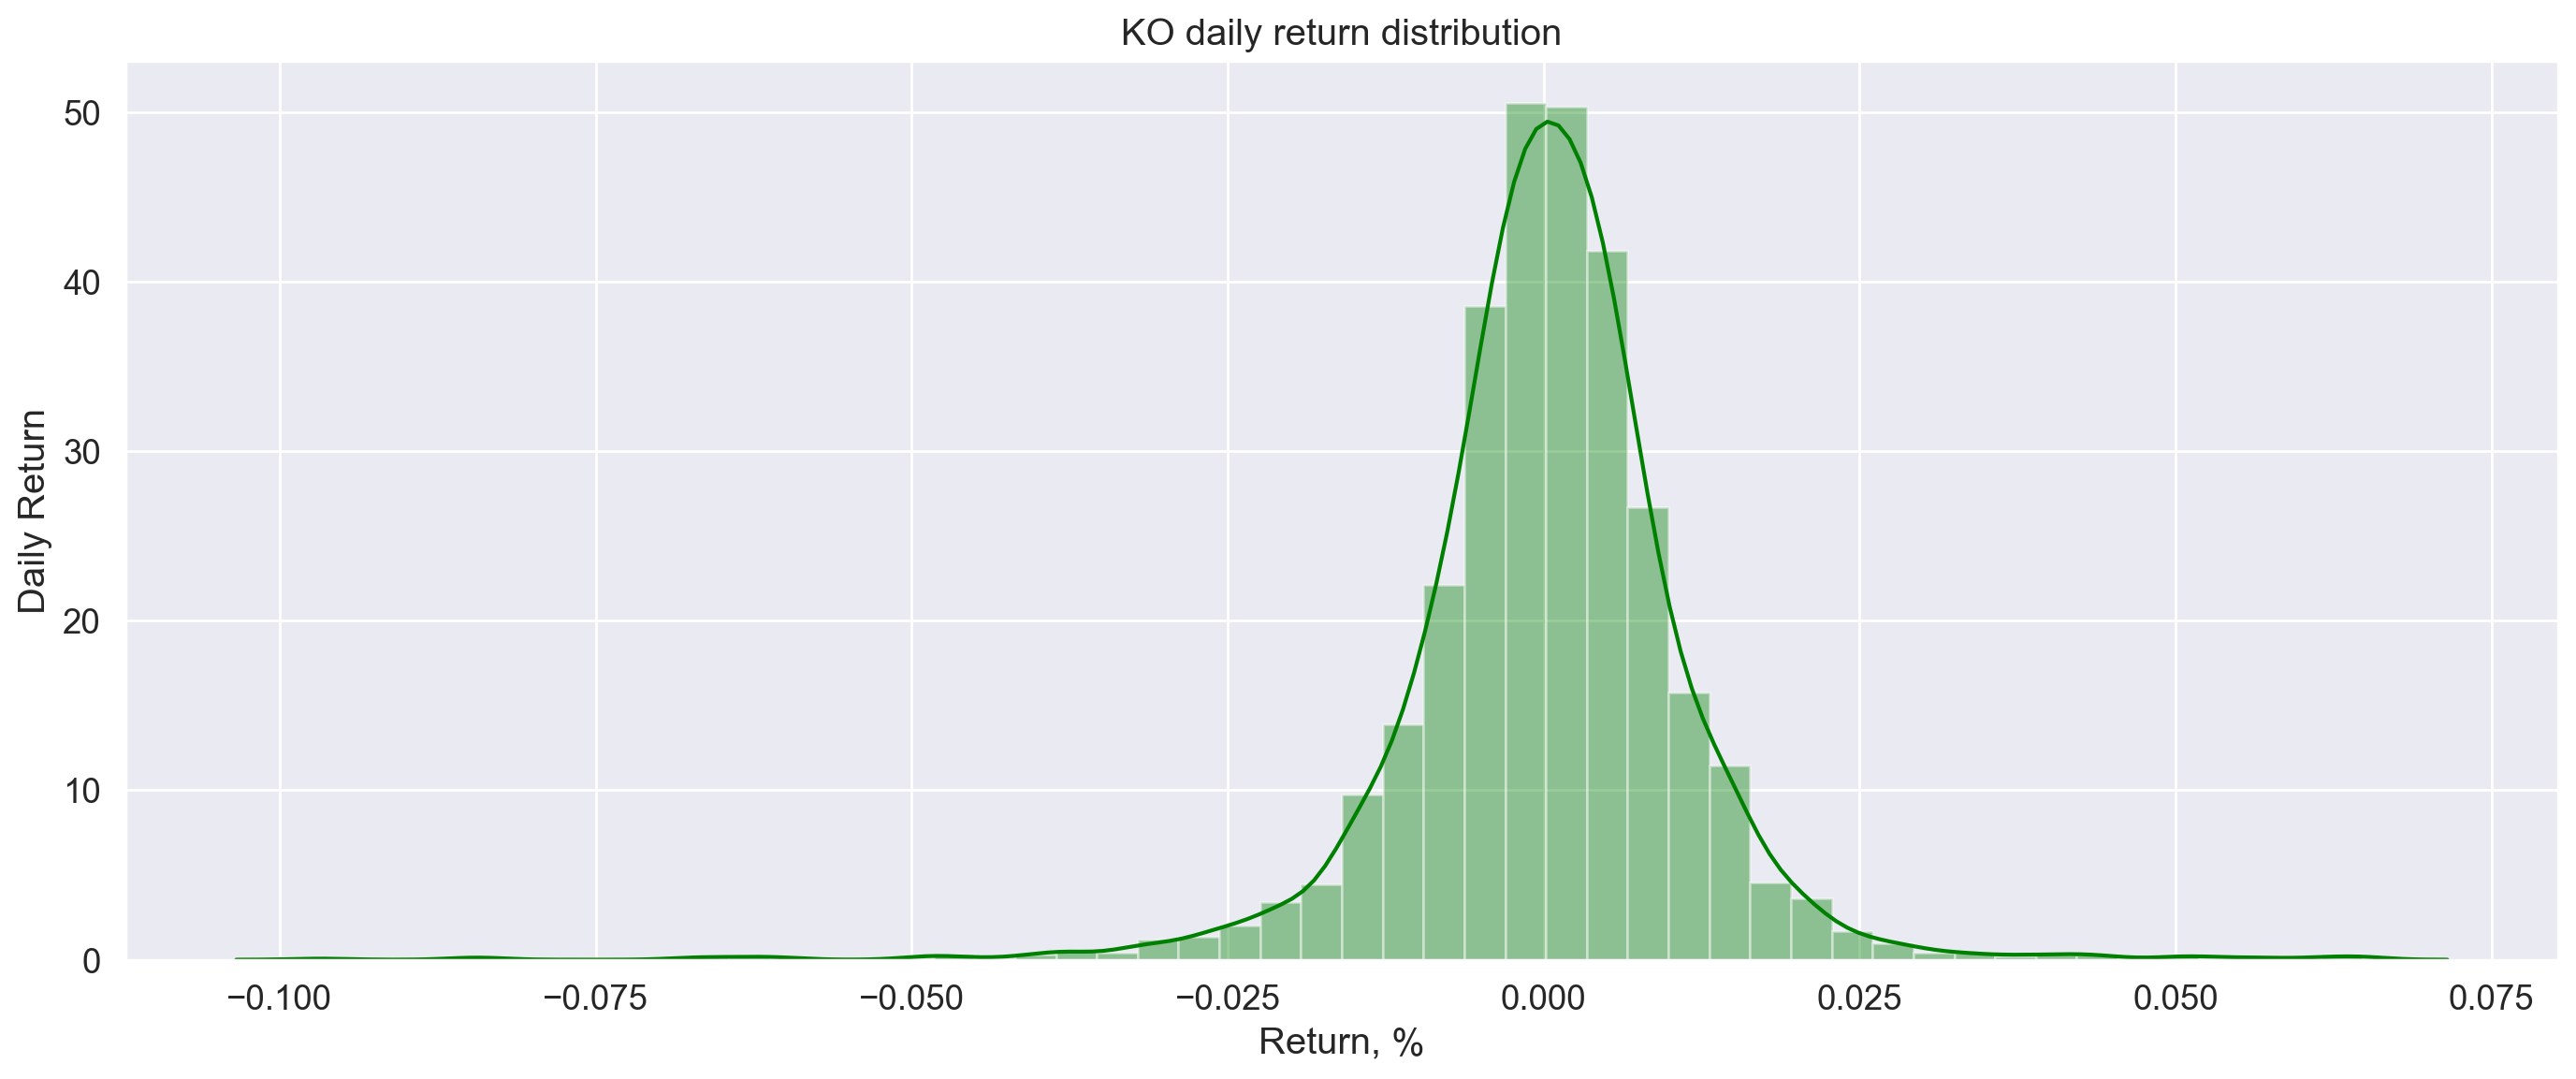

In [6]:
plt.figure(figsize=(14, 6), dpi=200)
sns.distplot(df['return'].dropna(), bins=50, color='green')
plt.ylabel('Daily Return')
plt.xlabel('Return, %')
plt.title('KO daily return distribution')
plt.tight_layout()

## 1.4 Technical indicators generation

Add all TA features using opensources Technical Analysis library.

In [7]:
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
df = df.drop(['trend_psar_up', 'trend_psar_down'], axis = 1)
df = df[71:-1] #to skip NuNs genrated for moving avarages etc.
df.head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2010-04-16  27.115000  27.570000  27.084999  27.485001  19.236176  35075600   
2010-04-19  27.490000  27.660000  27.459999  27.660000  19.358648  26468600   
2010-04-20  27.610001  27.645000  27.160000  27.235001  19.061197  32508800   
2010-04-21  27.285000  27.290001  27.000000  27.094999  18.963219  19263200   
2010-04-22  27.070000  27.254999  27.000000  27.155001  19.005209  20295600   

              return    volume_adi  volume_obv  volume_cmf  ...  momentum_wr  \
Date                                                        ...                
2010-04-16  0.013085  1.294820e+08    39486600    0.133260  ...   -27.830160   
2010-04-19  0.006367  1.559506e+08    65955200    0.142880  ...   -11.320819   
2010-04-20 -0.015365  1.334961e+08    33446400    0.098171  ...   -51.415035   
2010-04-21 -0.005140  1.268535e+08    14183200    0.037189  ...   -64.622687   
2010-04-22  0.002214  1.312312e+08    34478800    0.089530  ...   -58.962188   

            momentum_ao  momentum_kama  momentum_roc  momentum_ppo  \
Date                                                                 
2010-04-16     0.179383      27.255297      0.182253     -0.704730   
2010-04-19     0.192882      27.262219      0.581818      1.424443   
2010-04-20     0.166515      27.262004     -1.500901      5.116061   
2010-04-21     0.100603      27.259730     -1.221294      3.281575   
2010-04-22     0.087353      27.257648      0.036840      2.152398   

            momentum_ppo_signal  momentum_ppo_hist  others_dr  others_dlr  \
Date                                                                        
2010-04-16            -6.467657           5.762927   1.308520    1.300033   
2010-04-19            -4.889237           6.313680   0.636708    0.634690   
2010-04-20            -2.888178           8.004238  -1.536512   -1.548439   
2010-04-21            -1.654227           4.935802  -0.514049   -0.515375   
2010-04-22            -0.892902           3.045301   0.221448    0.221203   

            others_cr  
Date                   
2010-04-16  -3.629032  
2010-04-19  -3.015430  
2010-04-20  -4.505609  
2010-04-21  -4.996498  
2010-04-22  -4.786114  

[5 rows x 88 columns]

In [8]:
df.shape

(2851, 88)

## 1.5 Train-test split

* train: `16.04.2010` - `31.12.2019`
* test: `02.01.2020` - `31.12.2020`
* final validation: `01.04.2021` - `13.08.2021`

In [9]:
df_train = df[df.index < '2020-01-01']
df_test = df[('2020-01-01' < df.index) & (df.index < '2021-01-01')]
df_final = df[('2021-01-01' < df.index) & (df.index <= '2021-08-13')]
df = df[df.index < '2021-01-01'] # train + test

In [10]:
print(df_train.shape, df_test.shape, df_final.shape)

(2445, 88) (253, 88) (153, 88)


In [11]:
fig = go.Figure()
fig.update_layout(
    title=f"Train/test/validation split for {ticker} ticker",
    xaxis_title="Year",
    yaxis_title="Close price, USD")

fig.add_trace(go.Scatter(x=df_train.index, y=df_train.Close, name='Training'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test.Close, name='Test'))
fig.add_trace(go.Scatter(x=df_final.index,  y=df_final.Close,  name='Final'))
fig.show()

---

# 2. Traiding strategies based on technical indicators 

## 2.1. Moving Average Convergence Divergence (MACD)  strategy

Moving Average Convergence Divergence is a trading indicator that focuses on exponential moving average (EMA). Which might be calculate as follows:


1. $MACD = EMA(n_1, close) — EMA(n_2, close)$


2. $MACD_{Signal} = EMA(n_3, MACD)$


3. $MACD_{Difference} = MACD — MACD_{Signal}$

Here:

$n_1=12$, $n_2=26$ and $n_3=9$

In [12]:
df[['trend_macd', 'trend_macd_signal', 'trend_macd_diff']].head()

trend_macd  trend_macd_signal  trend_macd_diff
Date                                                      
2010-04-16    0.039923           0.030545         0.009379
2010-04-19    0.064153           0.037266         0.026887
2010-04-20    0.048503           0.039514         0.008989
2010-04-21    0.024521           0.036515        -0.011994
2010-04-22    0.010238           0.031260        -0.021022

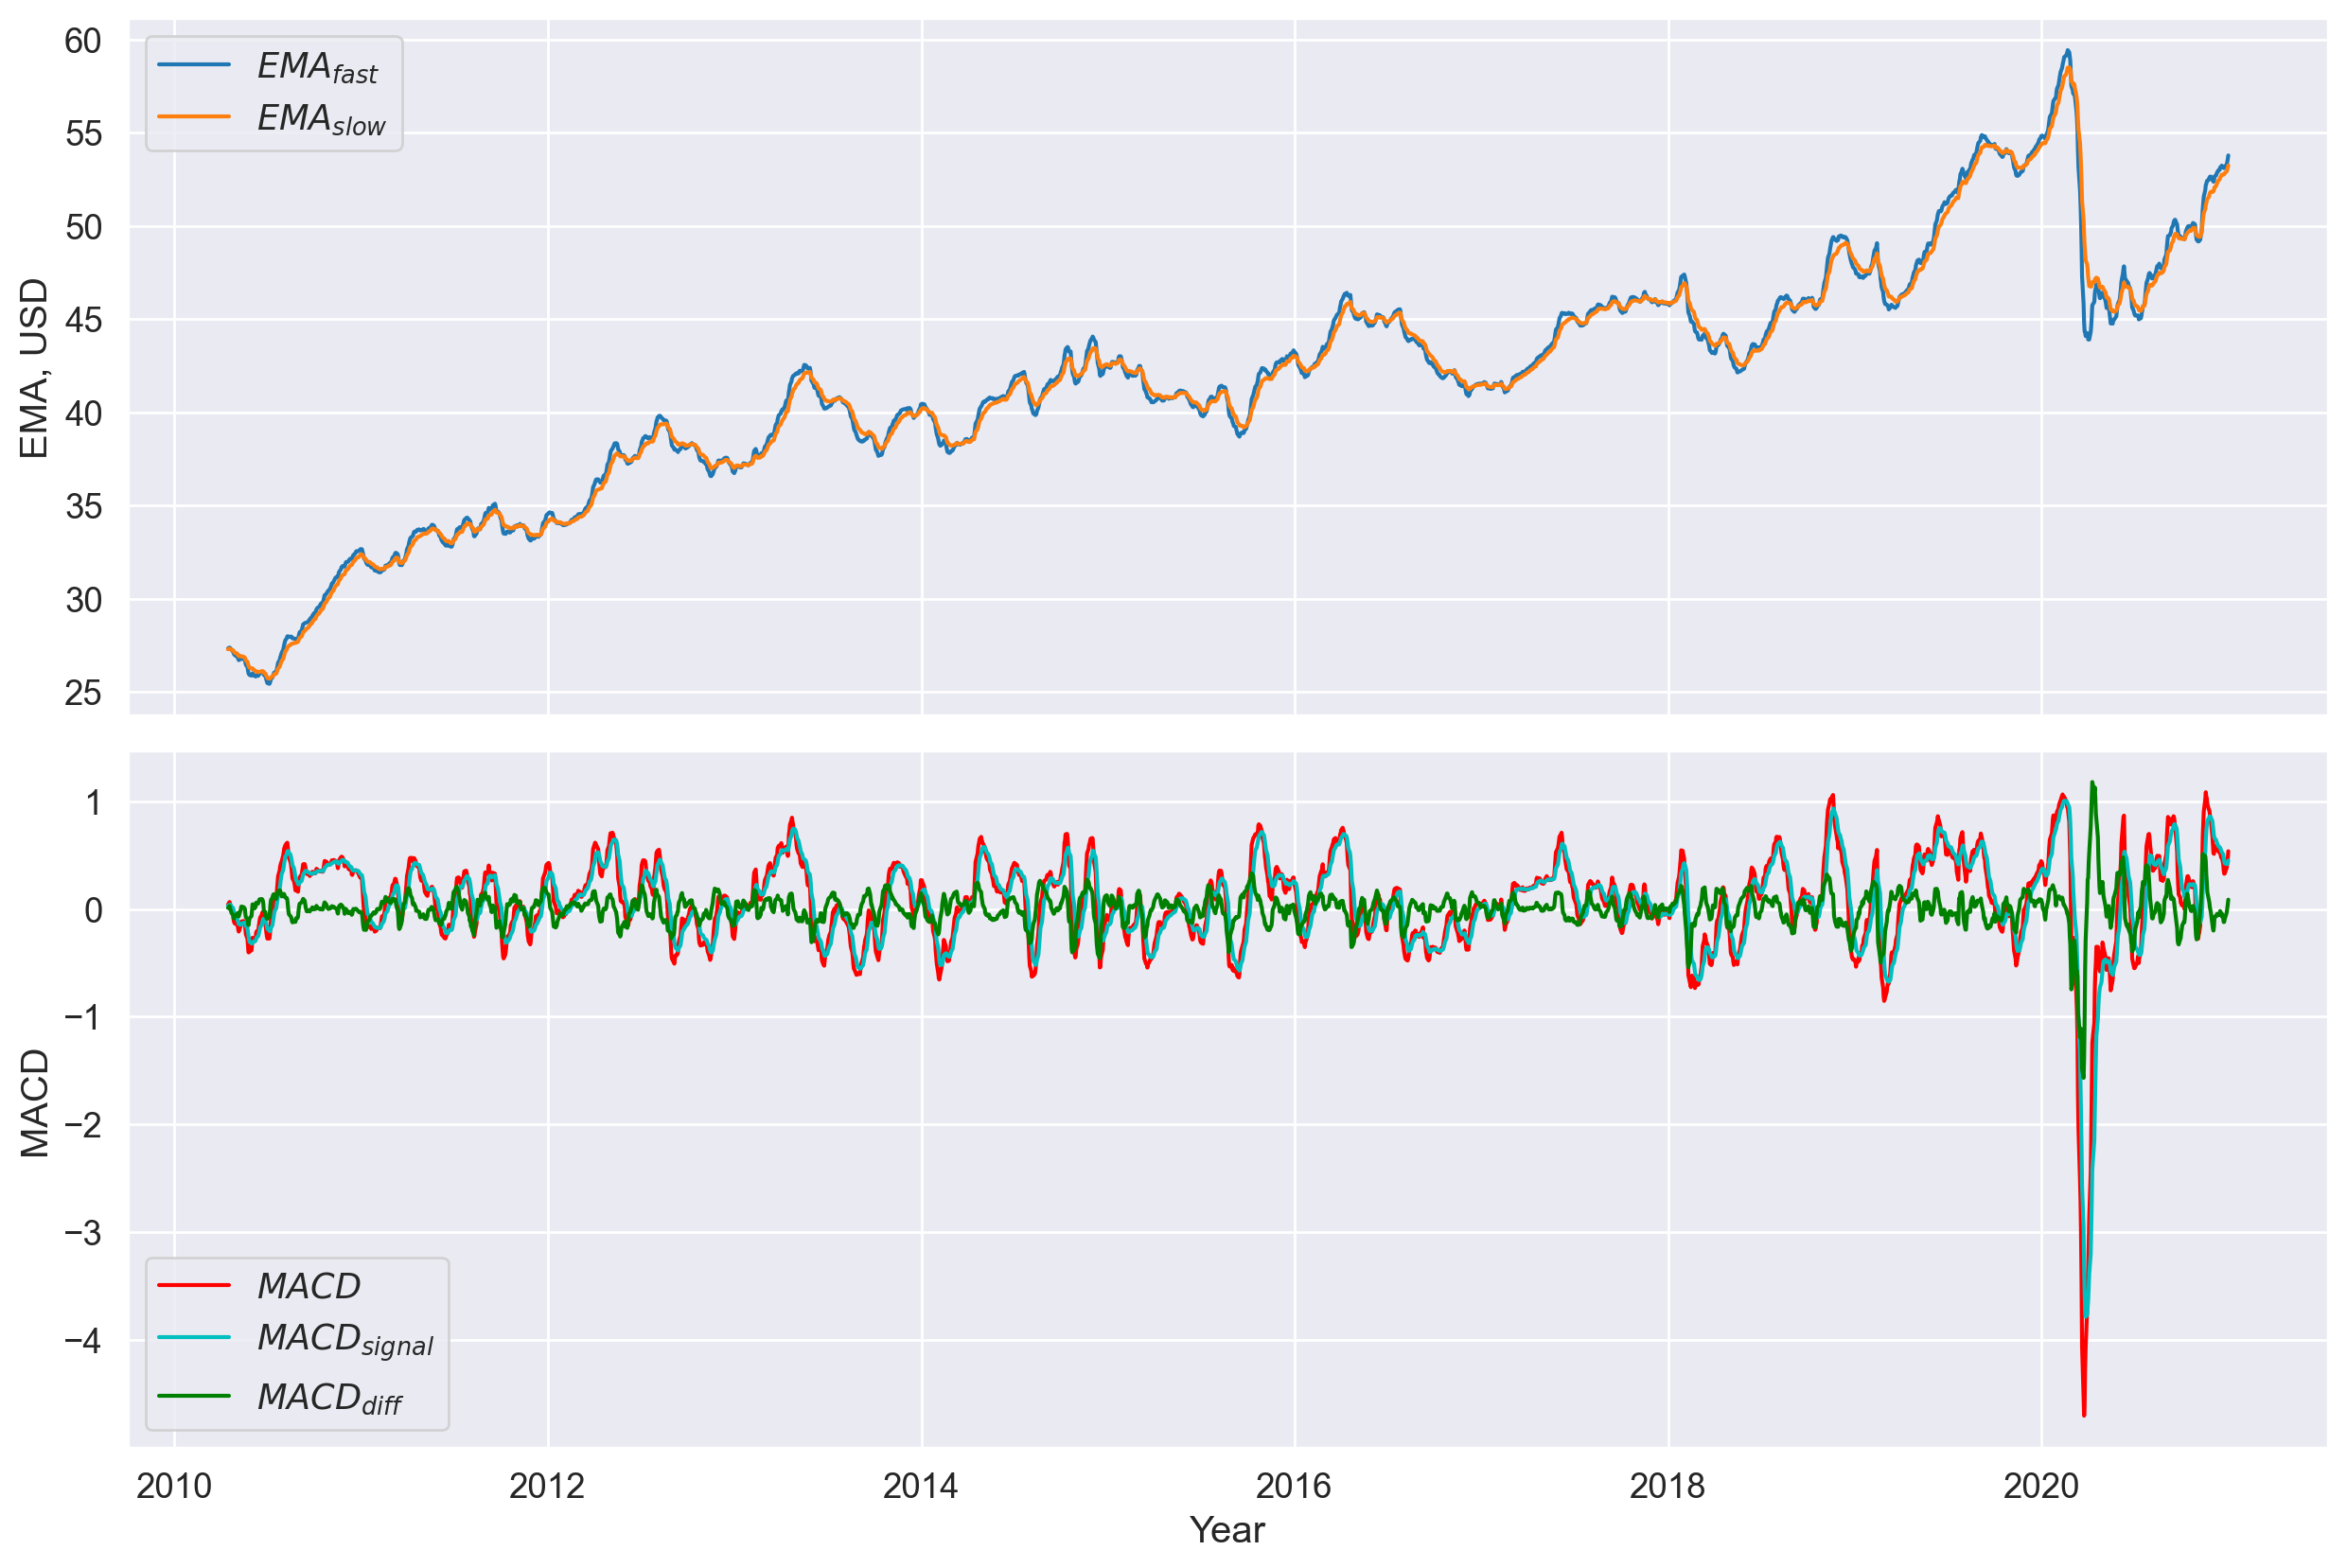

In [13]:
fig, axs = plt.subplots(ncols=1, nrows = 2, figsize=(15,10), sharex=True, dpi=200)
fig.subplots_adjust(hspace=0.05)
sns.lineplot(x = df.index, y=df.trend_ema_fast, label='$EMA_{fast}$', ax=axs[0])
sns.lineplot(x = df.index, y=df.trend_ema_slow, label='$EMA_{slow}$', ax=axs[0])
axs[0].set_ylabel('EMA, USD')

sns.lineplot(x=df.index, y=df.trend_macd, color='r', label='$MACD$', ax=axs[1])
sns.lineplot(x=df.index, y=df.trend_macd_signal, color='c', label='$MACD_{signal}$', ax=axs[1])
sns.lineplot(x=df.index, y=df.trend_macd_diff, color='g', label='$MACD_{diff}$', ax=axs[1])
axs[1].set_ylabel('MACD')
axs[1].set_xlabel('Year')
plt.show()

### 2.1.1 Generating of buy/sold signals given by MACD

Logic behind this signal as follows:
* if $MACD$ > $MACD_{signal}$ i.e. blue line on the plot is above green line we have a signal to `buy (1)`,
* otherwise in $MACD$ < $MACD_{signal}$ we have signal to `sold (-1)`.

##### Let's have a look on a number of buy/sold signal given by MACD.


In [14]:
df['macd_signal'] = 2 * (df['trend_macd'] < df['trend_macd_signal']) - 1

num_macd_signals = df['macd_signal'].value_counts()
print(f'Long:  {num_macd_signals[1]} days')
print(f'Short: {num_macd_signals[-1]} days')

Long:  1236 days
Short: 1462 days


### 2.1.2 Calculating of MACD strategy return concerning the buy/sold signals.

Hereby it's important to keep in mind that we must multiply by the signal of the previous day since we don't know information about the future. That's we shift the `return` and then apply our signal.

In [15]:
macd_return = np.array(df['return'][1:]) * np.array(df['macd_signal'][:-1])
macd_risk = np.std(macd_return) * 252 ** 0.5 * 100
macd_profit = np.prod(1 + macd_return) * 100

print(f"MACD total return: {macd_profit:.2f}%")
print(f'MACD risk:         {macd_risk:.2f}%')

MACD total return: 207.85%
MACD risk:         17.62%


---

## 2.2 Relative Strength Index (RSI) strategy

### 2.2.1 Generating of buy/sold/hold signals given by RSI strategy

The logic behind this signal is as follows:
* If the value of `30 < RSI < 70` we consider that stock is neither oversold nor overbought and do not trade it `signal = 0`
* If `RSI > 70` we decide that stock is overbought and we open short position `signal = (-1)`
* If `RSI < 30` we treat stock as an oversold and open long position `signal = 1`

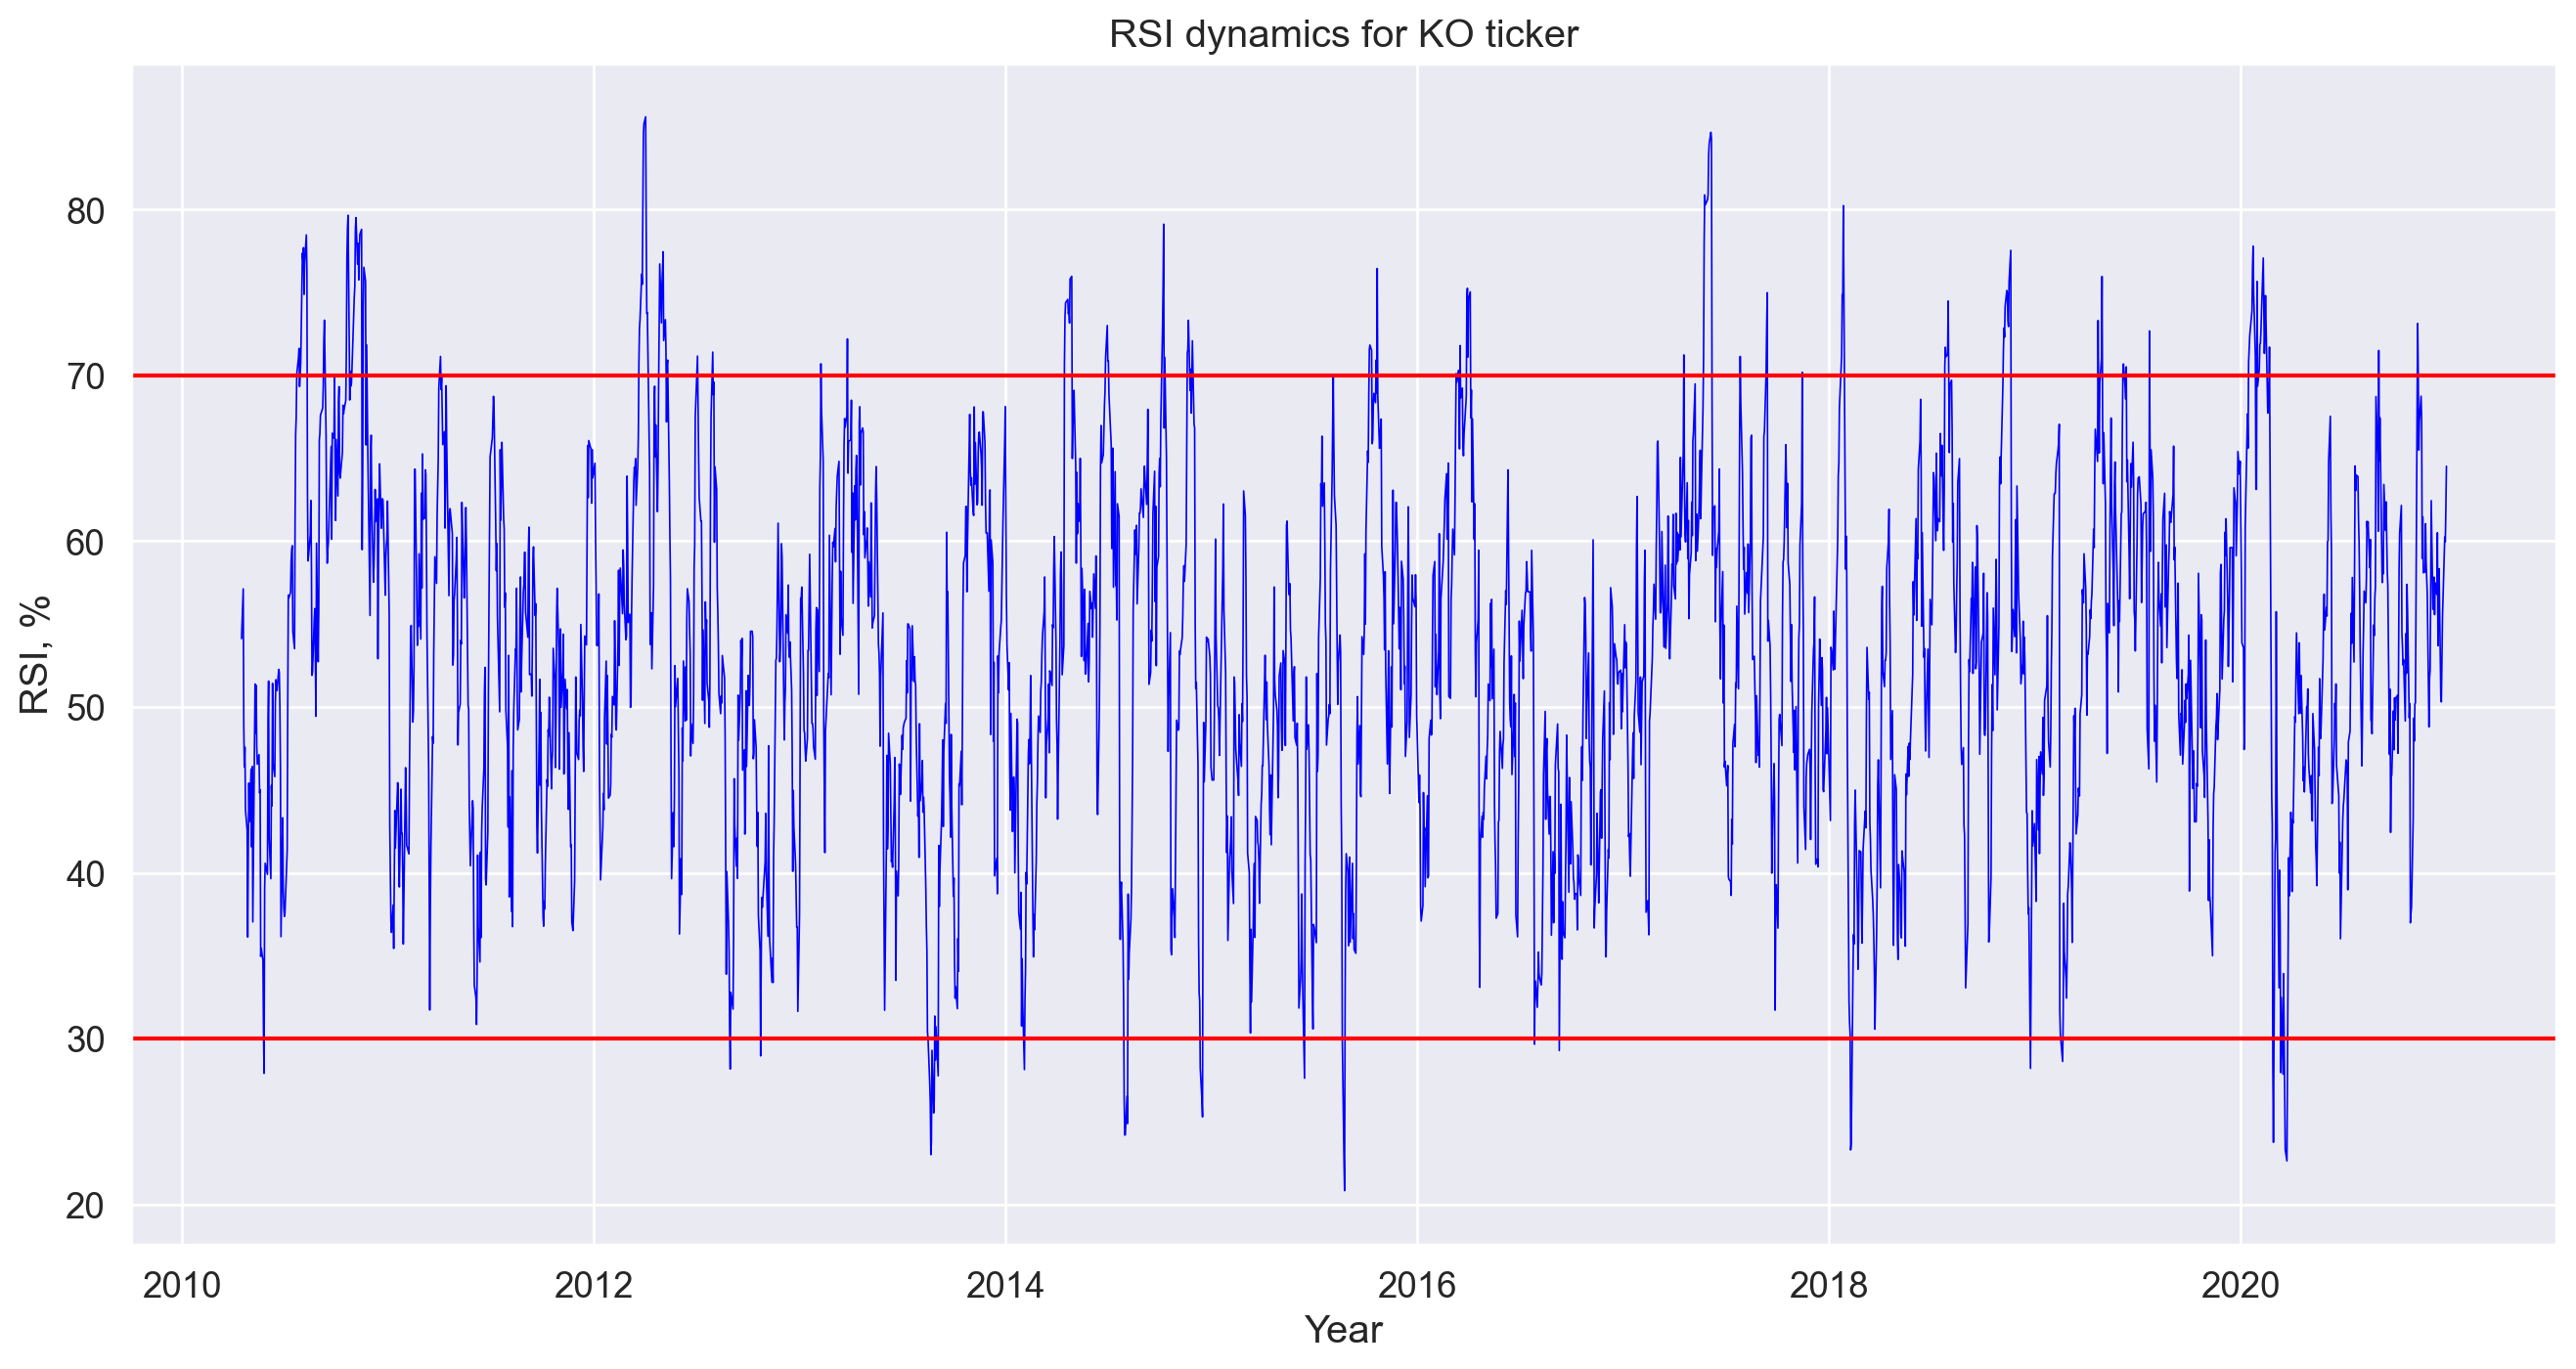

In [16]:
rsi_oversold = 30 # сигнал о перепроданности акции / покупаем
rsi_overbought = 70 # сигнал о перекупленности акции / продаем
df['rsi_signal'] = 1 * (df['momentum_rsi'] < rsi_oversold) - 1 * (df['momentum_rsi'] > rsi_overbought)

plt.figure(figsize=(16,8), dpi=200)
sns.lineplot(x=df.index, y = df['momentum_rsi'], color='b', linewidth=0.6)
plt.axhline(y = rsi_oversold, color = 'r', linestyle = '-')
plt.axhline(y = rsi_overbought, color = 'r', linestyle = '-')
plt.title(f"RSI dynamics for {ticker} ticker")
plt.ylabel("RSI, %")
plt.xlabel("Year")
plt.show()

##### Let's have a look on a number of buy/sold signal given by RSI.


In [17]:
num_rsi_signals = df['rsi_signal'].value_counts()
print(f'Cash:  {num_rsi_signals[0]} days')
print(f'Long:  {num_rsi_signals[1]} days')
print(f'Short: {num_rsi_signals[-1]} days')

Cash:  2495 days
Long:  39 days
Short: 164 days


### 2.2.2 Calculating of RSI strategy return concerning the buy/sold signals.

In [18]:
rsi_return = np.array(df['return'][1:]) * np.array(df['rsi_signal'][:-1])
rsi_profit = np.prod(1 + rsi_return) * 100
rsi_risk = np.std(rsi_return) * 252 ** 0.5 * 100

print(f"RSI total return: {rsi_profit:.2f}%")
print(f'RSI risk:         {rsi_risk:.2f}%')

RSI total return: 128.34%
RSI risk:         5.51%


---

## 2.3 Support and Resistance (S&R) strategy

A number from `0` to `1` shows how close we are to the psychological level of support/resistance line, which for this case we simply count as round numbers (30, 40, 50, etc.).

In [19]:
df['SnR'] = (df['Close'] / 10 ** np.floor(np.log10(df['Close']))) % 1

### 2.3.1 Generating of buy/sold signals given by S&R strategy

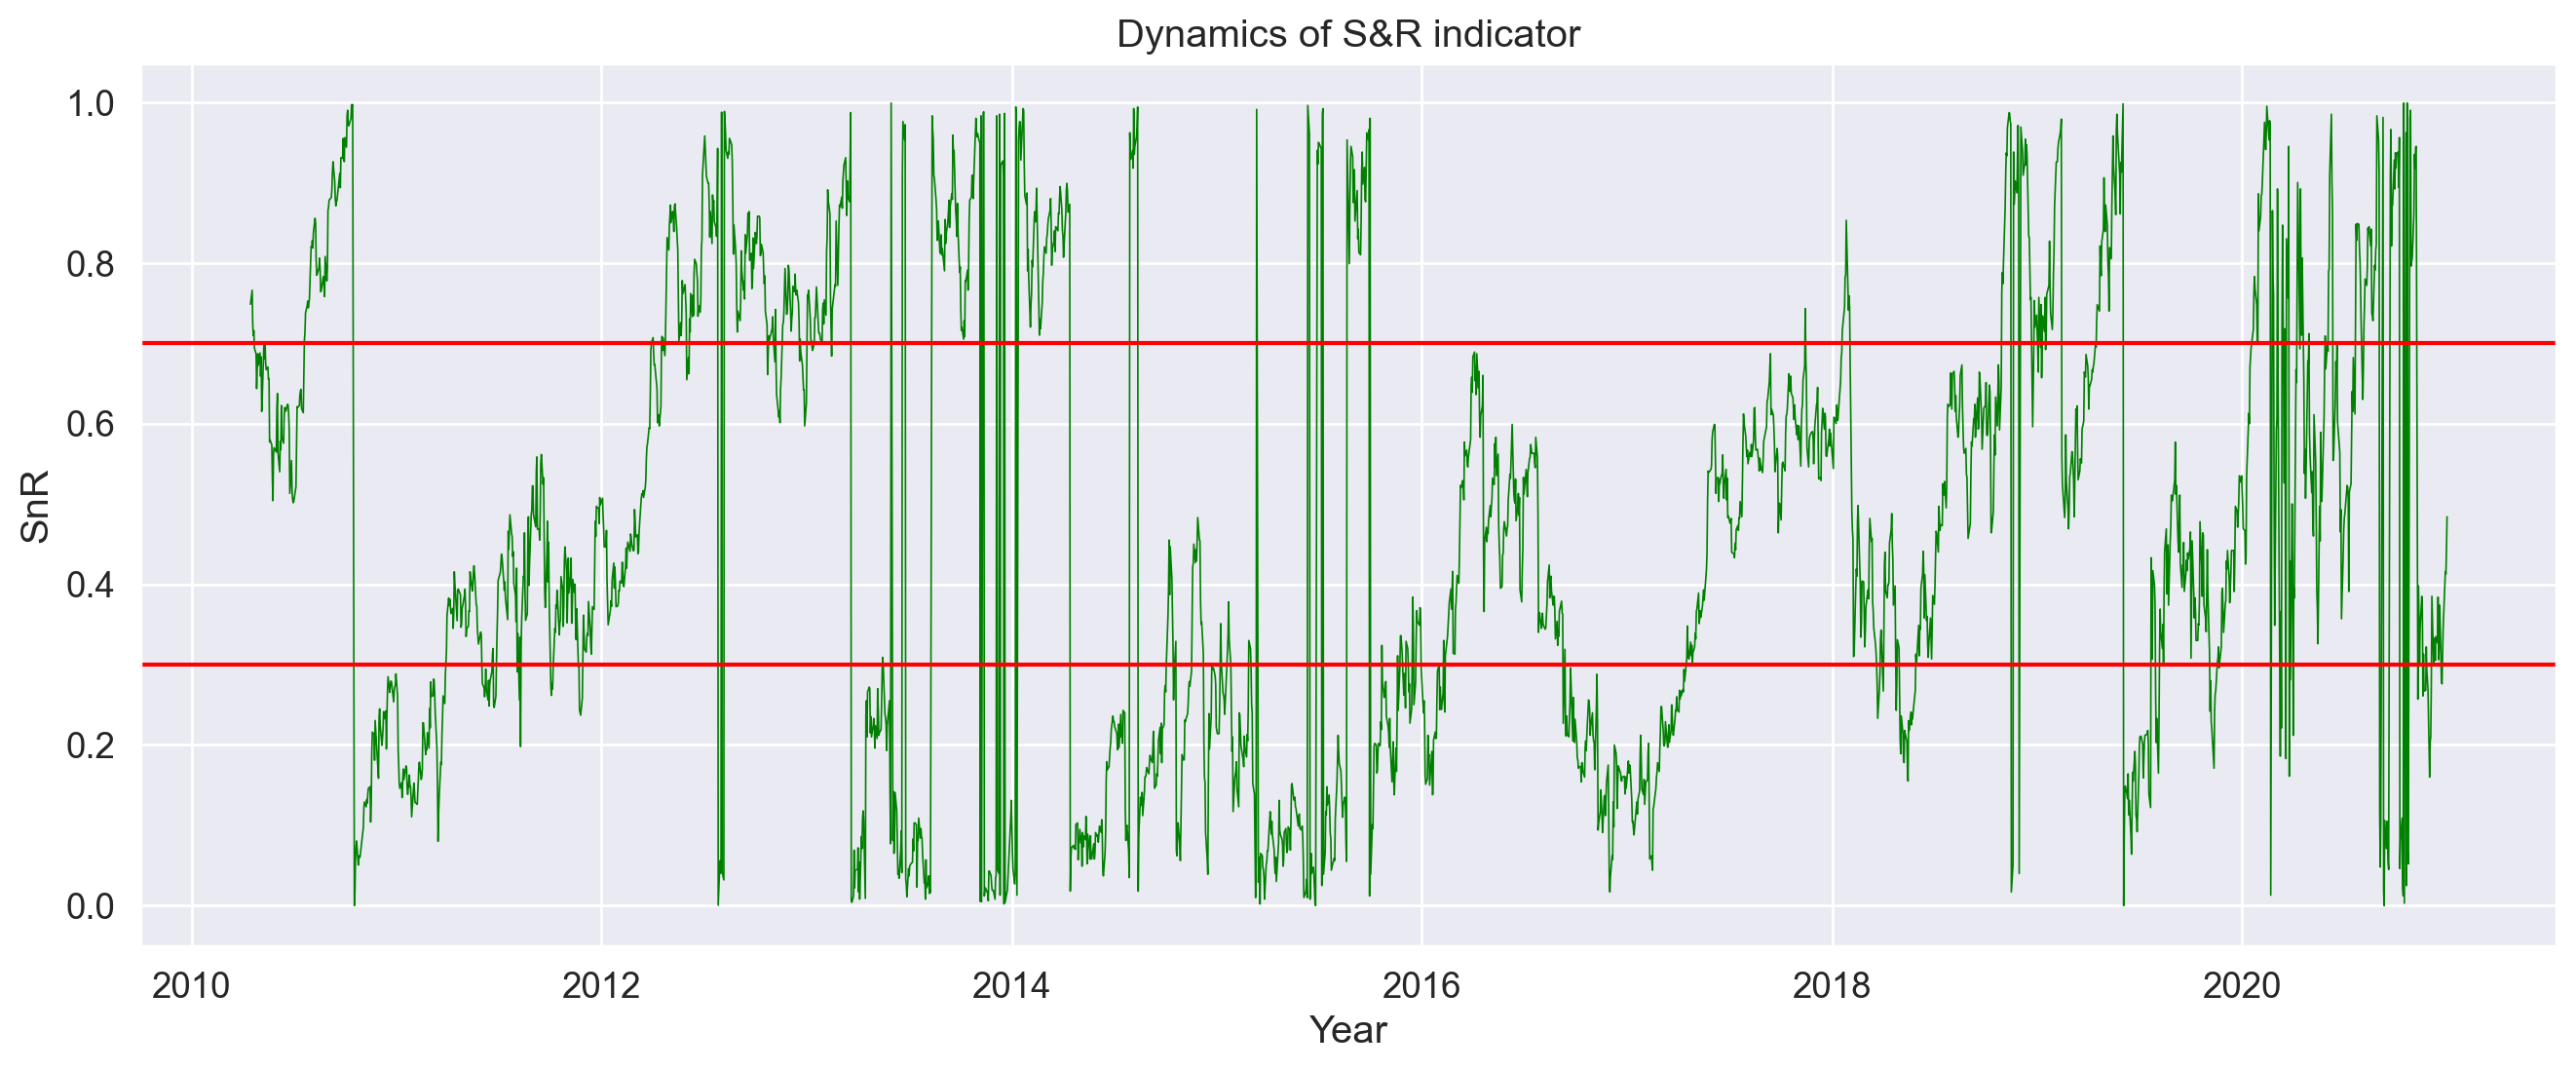

In [20]:
sr_sell = 0.7
sr_buy = 0.3
df['SnR_signal'] = 1 * (df['SnR'] < sr_buy) - 1 * (df['SnR'] > sr_sell)

plt.figure(figsize=(16,6), dpi=200)
sns.lineplot(x=df.index, y = df['SnR'], color='g', linewidth=0.6)
plt.axhline(y = sr_sell, color = 'r', linestyle = '-')
plt.axhline(y = sr_buy, color = 'r', linestyle = '-')
plt.title('Dynamics of S&R indicator')
plt.xlabel("Year")
plt.show()

##### Let's have a look on a number of buy/sold signal given by S&R.


In [21]:
num_of_signals = df['SnR_signal'].value_counts()
print(f'Cash:  {num_of_signals[0]} days')
print(f'Long:  {num_of_signals[1]} days')
print(f'Short: {num_of_signals[-1]} days')

Cash:  1123 days
Long:  907 days
Short: 668 days


In [22]:
snr_return = np.array(df['return'][1:]) * np.array(df['SnR_signal'][:-1])
snr_risk = np.std(snr_return) * 252 ** 0.5 * 100
snr_profit = np.prod(1 + snr_return)  * 100

print(f"S&R total return: {snr_profit:.2f}%")
print(f'S&R risk:         {snr_risk:.2f}%')

S&R total return: 121.53%
S&R risk:         13.54%


## 2.4 Buy and Hold (B&H) strategy.
Despite its simplicity, this strategy quite frequently outperforms some complicated technical indicators.
In this case, we assume that we bought stock and keep it till the end of the period. So in the signal will be just `1` for all trading days.

In [23]:
bnh_return = np.array(df['return'][1:])
bnh_risk = np.std(bnh_return) * 252 ** 0.5 * 100
bnh_profit = np.prod(1 + bnh_return)  * 100

print(f"B&H total return: {bnh_profit:.2f}%")
print(f'B&H risk:         {bnh_risk:.2f}%')

B&H total return: 199.53%
B&H risk:         17.62%


---

# Sharpe ratio


$$S_R = \frac{R_p - R_f}{\sigma_p}$$


$R_p$ - Return of portfolio

$R_f$ - Risk-free rate

$\sigma_p$ - Standart deviation of portfolio's excess Return


In [24]:
def sharpe_ratio(r, year_risk_free = 0.0025) -> float:
    daily_avg_return = np.prod(1 + r) / len(r)
    dayly_free_risk  = year_risk_free / 252
    daily_sharpe_ratio = (daily_avg_return - dayly_free_risk) / np.std(r) # Calculate Daily Sharpe Ratio
    sharpe_ratio = 252 ** 0.5 * daily_sharpe_ratio # Annualize Daily Sharpe Ratio
    return sharpe_ratio

macd_sharpe = sharpe_ratio(macd_return)
rsi_sharpe = sharpe_ratio(rsi_return)
snr_sharpe = sharpe_ratio(snr_return)
bnh_sharpe = sharpe_ratio(bnh_return) # Buy and Hold

print('Sharpe ratio:')
print(f'MACD    {macd_sharpe:.2f}')
print(f'RSI     {rsi_sharpe:.2f}')
print(f'S&R     {snr_sharpe:.2f}')
print(f'B&H     {bnh_sharpe:.2f}') 

Sharpe ratio:
MACD    1.09
RSI     2.13
S&R     0.82
B&H     1.04


# Ratio of accumulated profitability to maximum drawdown

In [25]:
def max_dropdown(r):
    return np.nan_to_num((np.maximum.accumulate(r) - r) / np.maximum.accumulate(r)).max()

macd_dropdown = max_dropdown(macd_return) * 100
rsi_dropdown = max_dropdown(rsi_return) * 100
snr_dropdown = max_dropdown(snr_return) * 100
bnh_dropdown = max_dropdown(bnh_return) * 100 # Buy and Hold

print('Maximum DropDown:')
print(f'MACD {macd_dropdown:.2f}%')
print(f'RSI  {rsi_dropdown:.2f}%')
print(f'S&R  {snr_dropdown:.2f}%')
print(f'B&H  {bnh_dropdown:.2f}%\n') 

macd_profit_drop_ratio = macd_profit / macd_dropdown
rsi_profit_drop_ratio = rsi_profit / rsi_dropdown
snr_profit_drop_ratio = snr_profit / snr_dropdown
bnh_profit_drop_ratio = bnh_profit / bnh_dropdown
print('Accumulated profitability to Maximum DropDown :')
print(f'MACD   {macd_profit_drop_ratio:.2f}')
print(f'RSI    {rsi_profit_drop_ratio:.2f}')
print(f'S&R    {snr_profit_drop_ratio:.2f}')
print(f'B&H    {bnh_profit_drop_ratio:.2f}') 

Maximum DropDown:
MACD 264.95%
RSI  285.76%
S&R  255.12%
B&H  373.46%

Accumulated profitability to Maximum DropDown :
MACD   0.78
RSI    0.45
S&R    0.48
B&H    0.53


#### Now let's have a look at the ratio between Profit, Risks and Sharpe ratios for all our strategies.

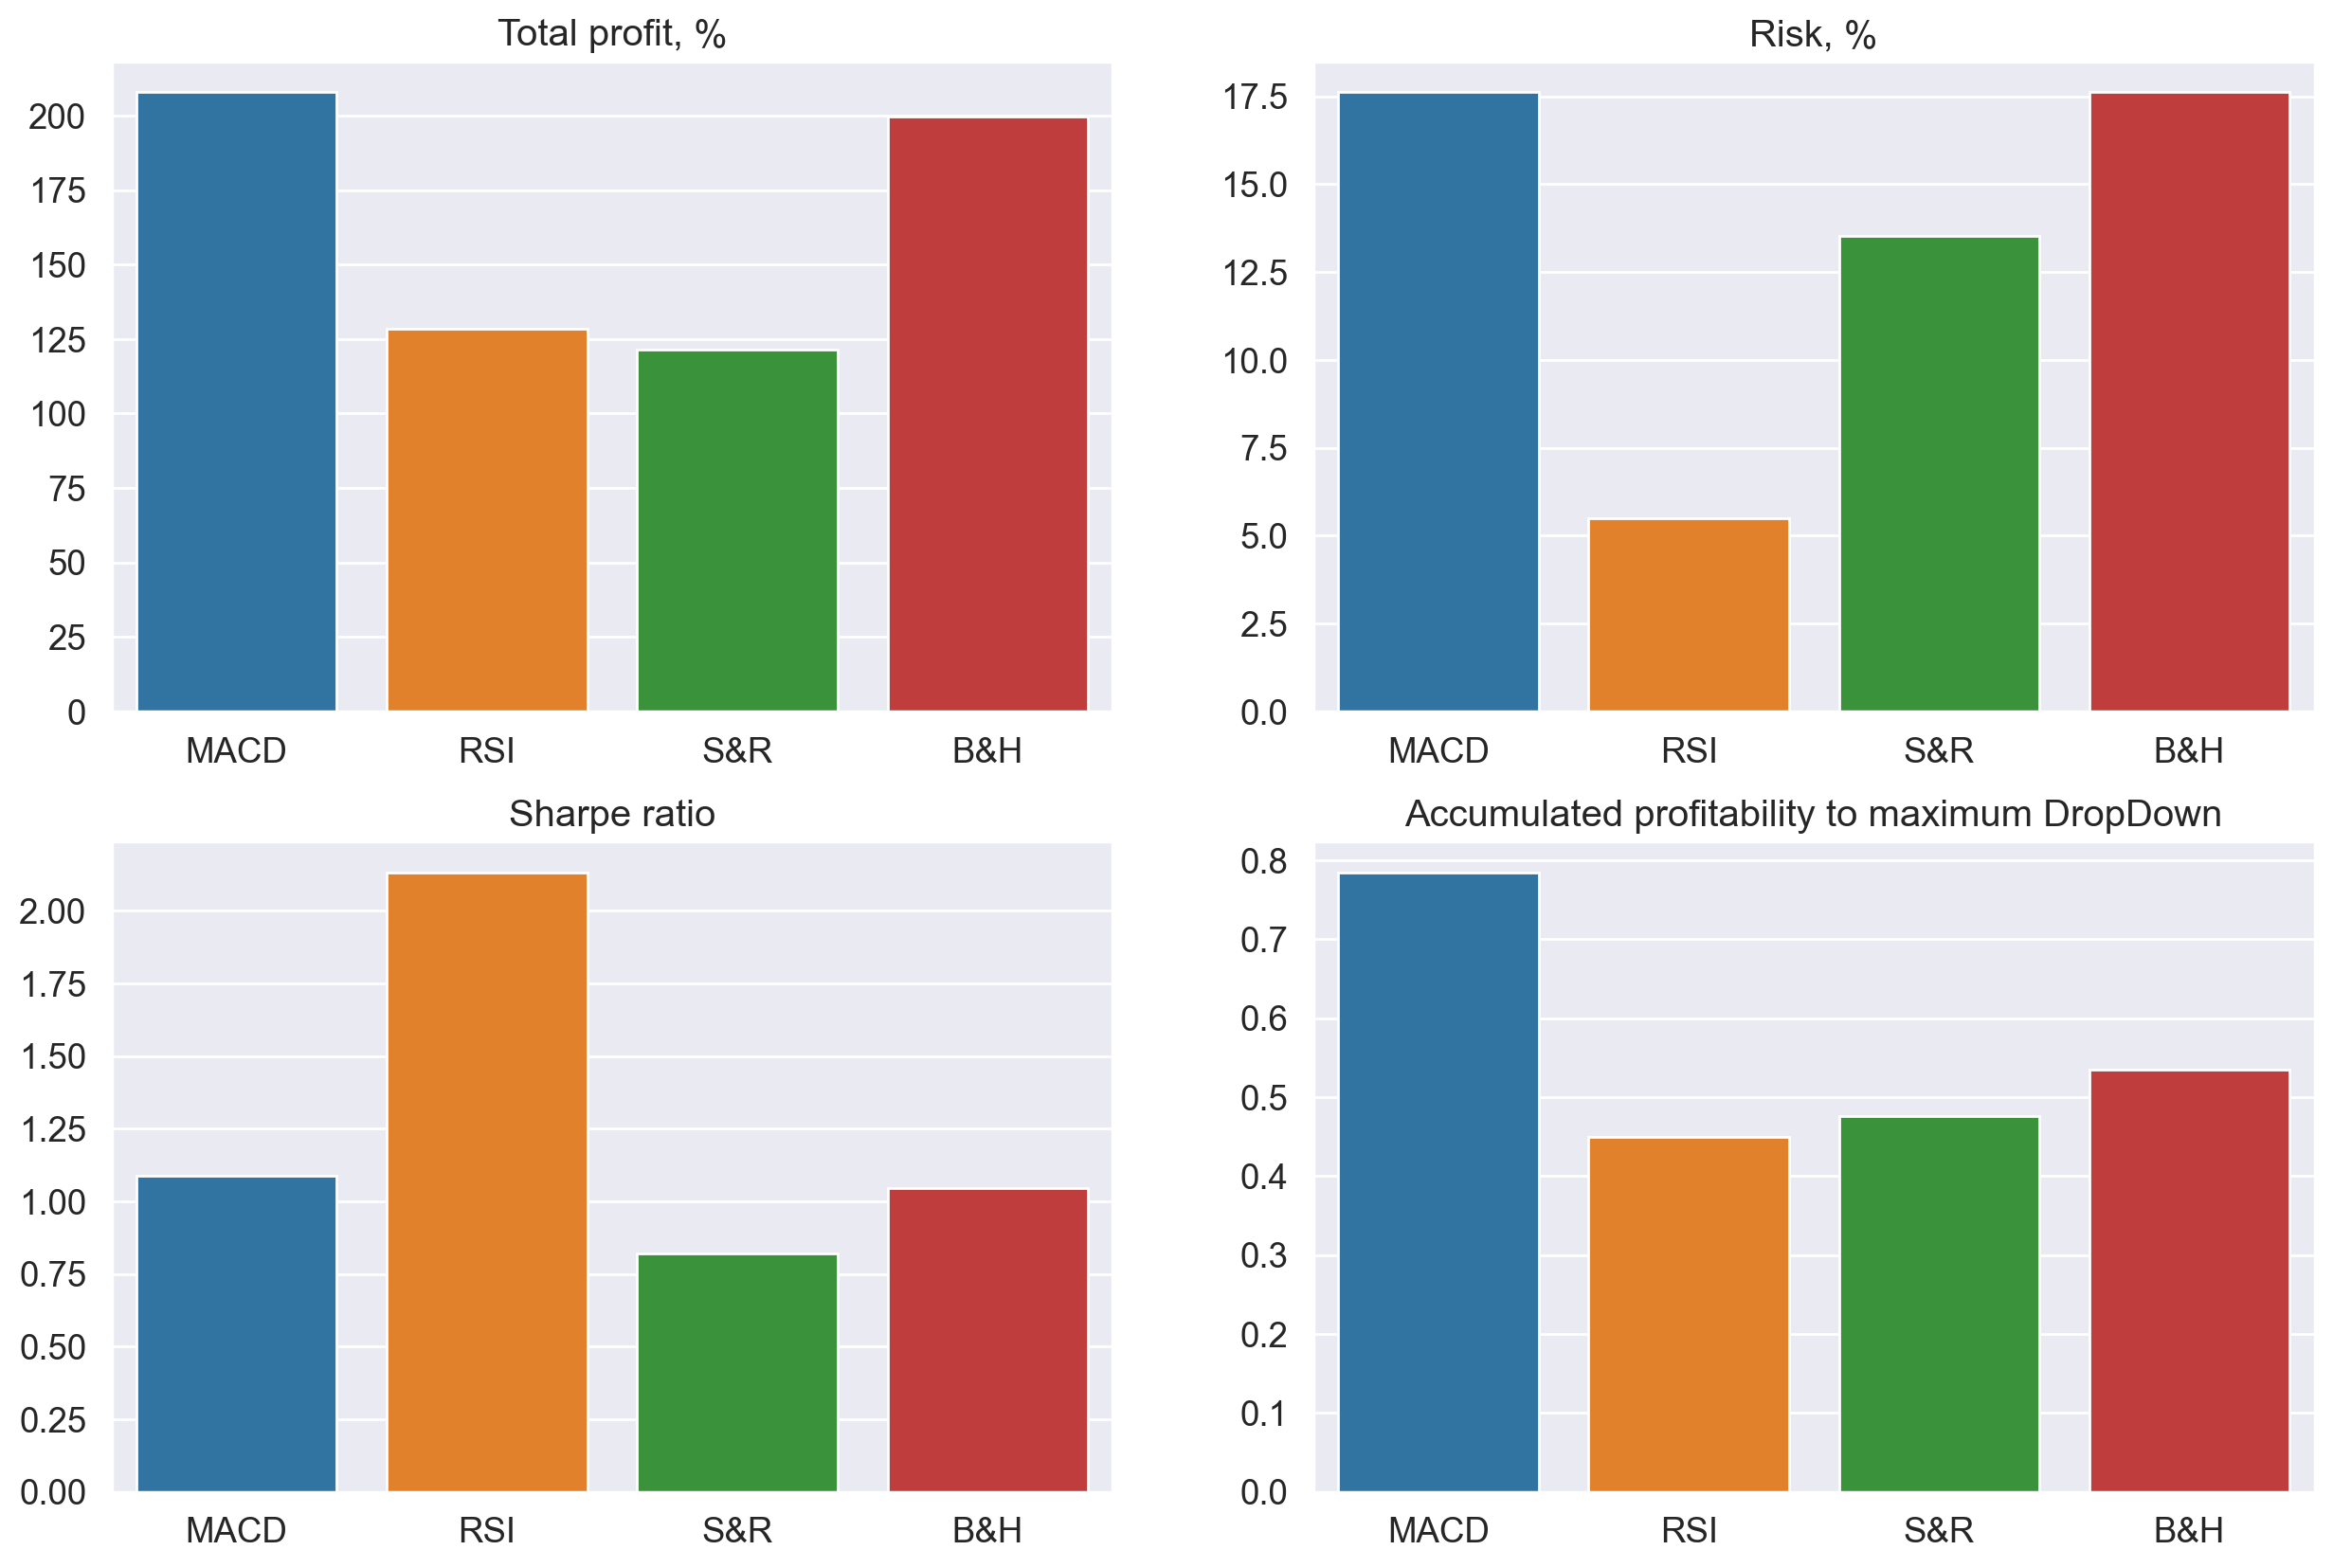

In [26]:
names_strategies = ['MACD', 'RSI', 'S&R', 'B&H']

fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(15,10), dpi=200)

sns.barplot(x = names_strategies,
            y = [macd_profit, rsi_profit, snr_profit, bnh_profit],
            ax=axs[0, 0])
axs[0, 0].set_title('Total profit, %')

sns.barplot(x = names_strategies,
            y = [macd_risk, rsi_risk, snr_risk, bnh_risk],
            ax=axs[0, 1])
axs[0, 1].set_title('Risk, %')

sns.barplot(x = names_strategies,
            y = [macd_sharpe, rsi_sharpe, snr_sharpe, bnh_sharpe],
            ax=axs[1, 0])
axs[1, 0].set_title('Sharpe ratio')

sns.barplot(x = names_strategies,
            y = [macd_profit_drop_ratio, rsi_profit_drop_ratio, snr_profit_drop_ratio, bnh_profit_drop_ratio],
            ax=axs[1, 1])
axs[1, 1].set_title('Accumulated profitability to maximum DropDown')
plt.show()

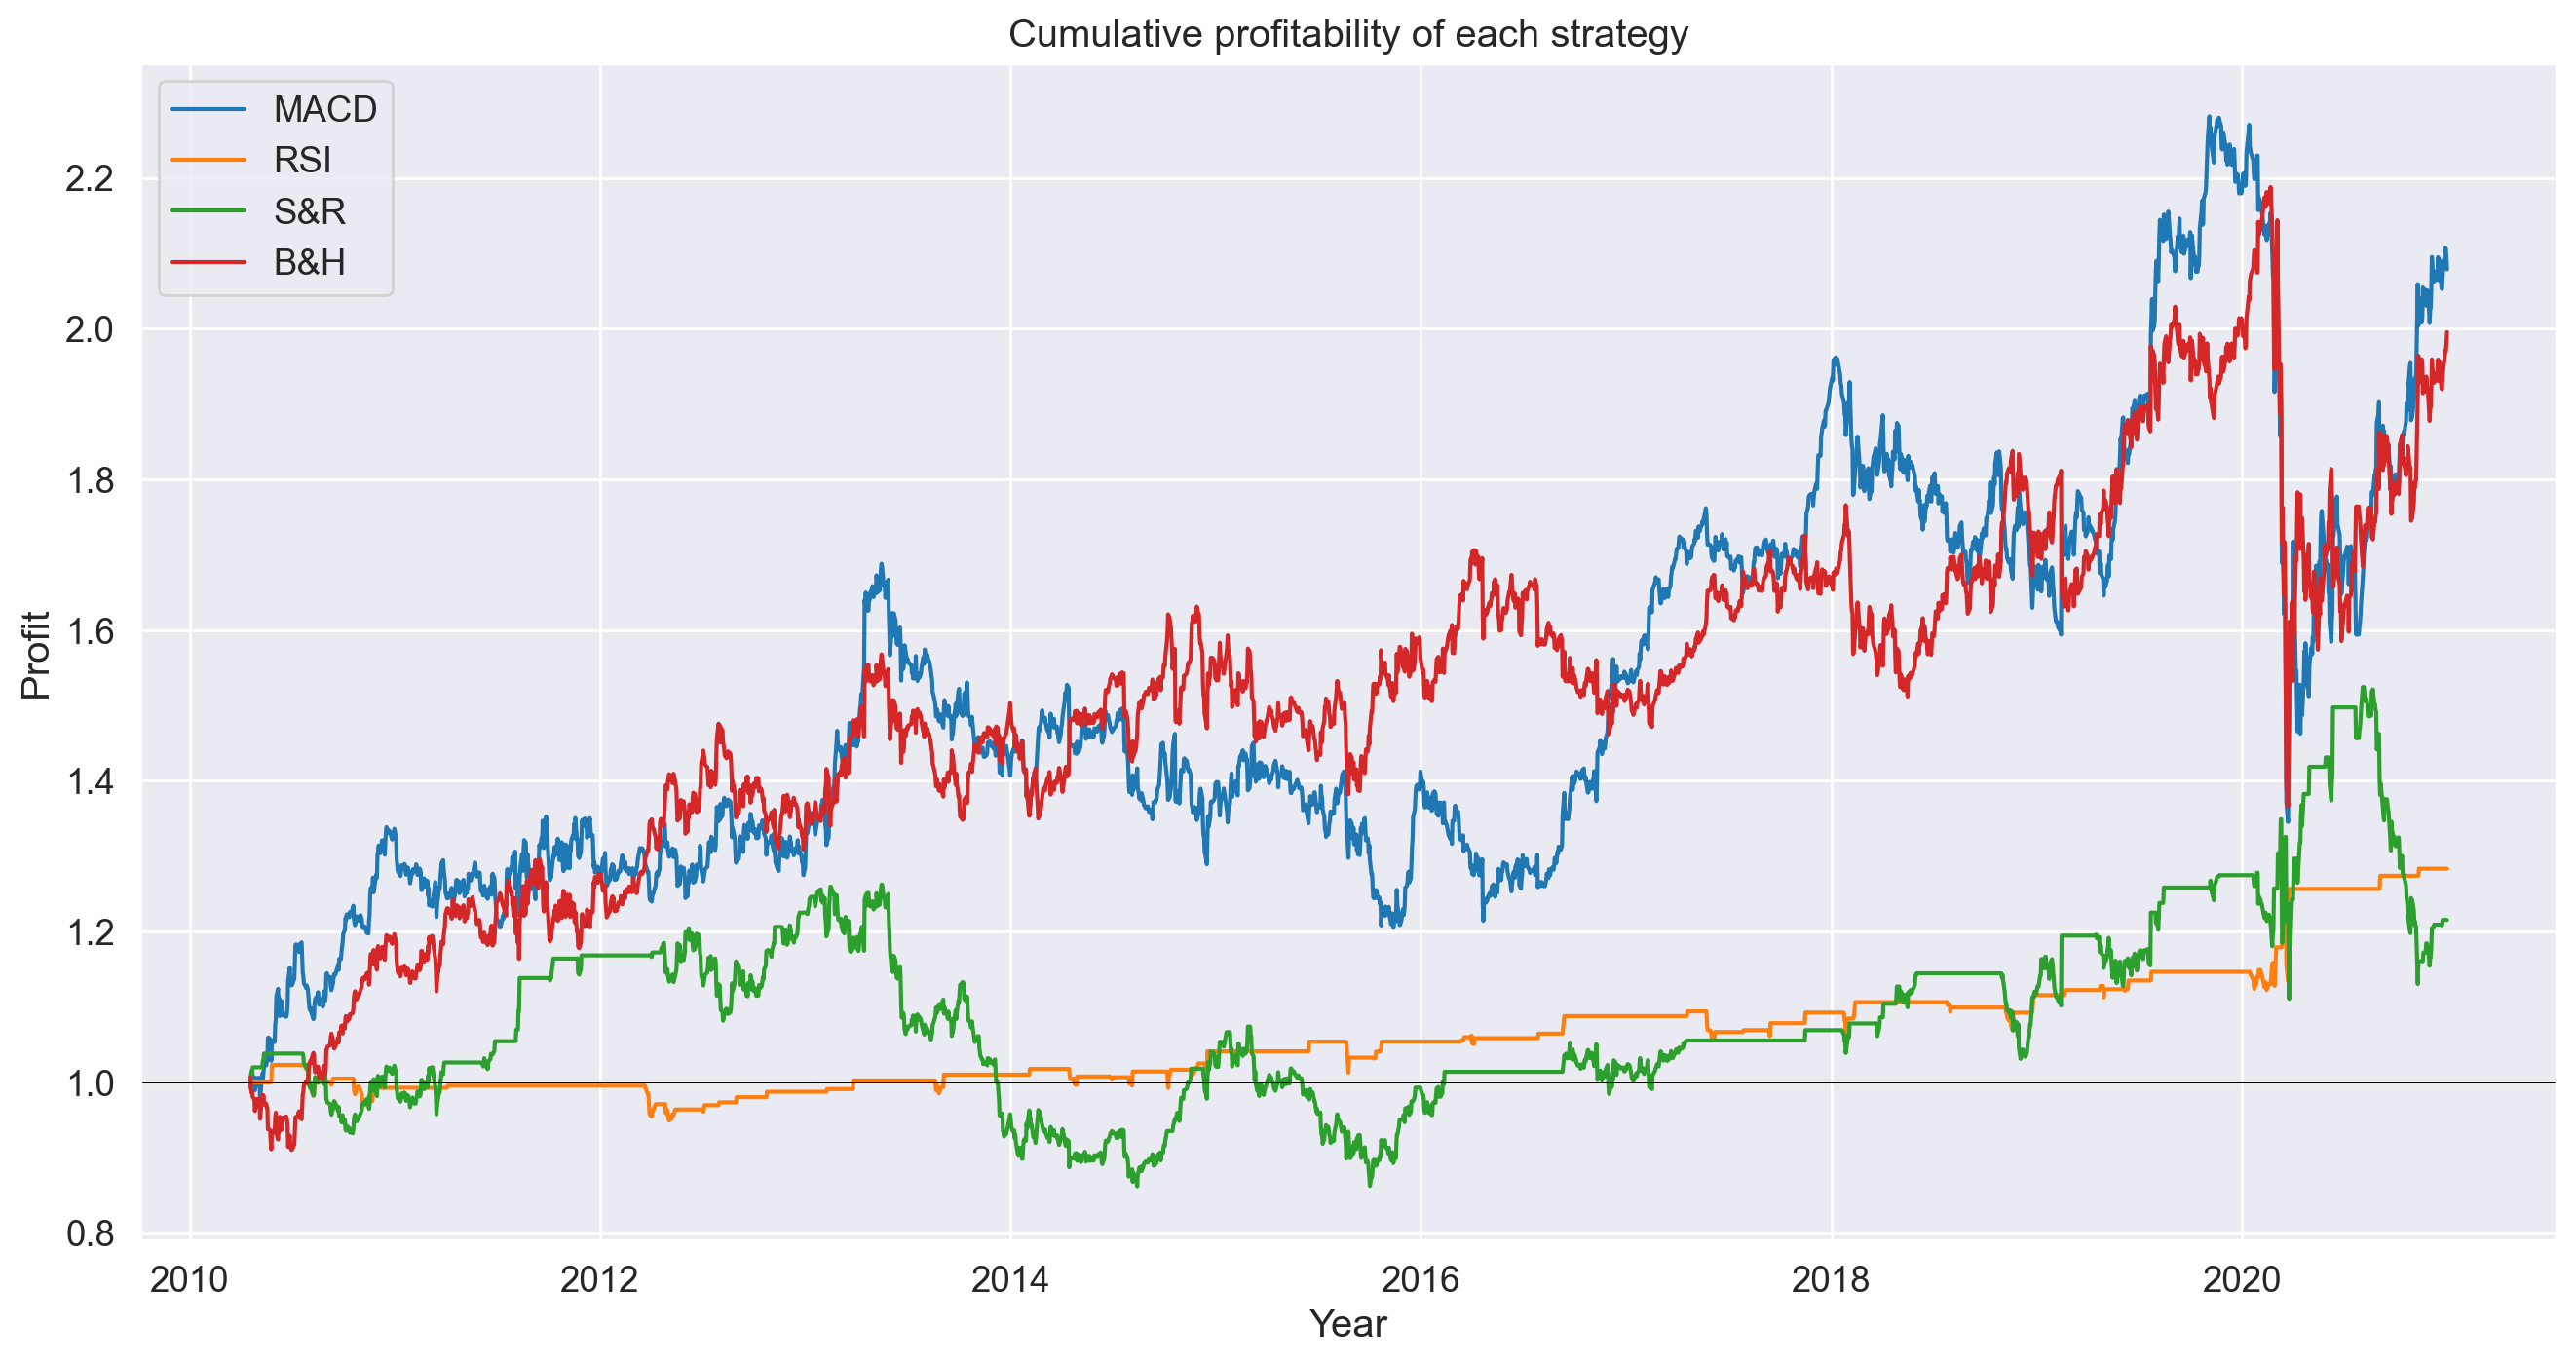

In [27]:
plt.figure(figsize=(16, 8), dpi=200)
dates = df.index[1:]
sns.lineplot(x=dates, y = np.cumprod(1 + macd_return), label = 'MACD')
sns.lineplot(x=dates, y = np.cumprod(1 + rsi_return), label = 'RSI')
sns.lineplot(x=dates, y = np.cumprod(1 + snr_return), label = 'S&R')
sns.lineplot(x=dates, y = np.cumprod(1 + bnh_return), label = 'B&H')
plt.axhline(1, c='black', linewidth=0.4)
plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Cumulative profitability of each strategy')
plt.legend()
# plt.savefig('report/fig/profit_ta.jpg')
plt.show()

#### Conclusion
As we may note from the presented plots `Relative Strength Index (RSI)` strategy have the highest value of `Sharpe ratio` and the lowest ratio of accumulated profitability to the maximum dropdown. Thus from the viewpoint of portfolio risks, this one is the best strategy for the chosen instrument.

# Applying the best strategy to validation data

Now we will apply strategy with the best parameters toward the validation `4 month` dataset `01.04.2021` - `13.08.2021`.

In [28]:
df_final.head(3)

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2021-01-04  54.270000  54.630001  52.029999  52.759998  51.544151  25611100   
2021-01-05  52.330002  52.619999  52.029999  52.180000  50.977520  20323800   
2021-01-06  51.970001  52.020000  50.189999  50.520000  49.355770  38724500   

              return    volume_adi  volume_obv  volume_cmf  ...  momentum_wr  \
Date                                                        ...                
2021-01-04 -0.037929  1.639400e+09  1989916000    0.013764  ...   -73.559370   
2021-01-05 -0.010993  1.629411e+09  1969592200   -0.084377  ...   -93.220315   
2021-01-06 -0.031813  1.604652e+09  1930867700   -0.135114  ...   -93.037939   

            momentum_ao  momentum_kama  momentum_roc  momentum_ppo  \
Date                                                                 
2021-01-04     0.930883      53.187455     -2.005947     -6.162677   
2021-01-05     0.604471      53.135526     -1.658502     -1.626363   
2021-01-06     0.058147      52.935805     -5.162380     10.581394   

            momentum_ppo_signal  momentum_ppo_hist  others_dr  others_dlr  \
Date                                                                        
2021-01-04            -8.862469           2.699792  -3.792855   -3.866656   
2021-01-05            -7.415248           5.788884  -1.099314   -1.105401   
2021-01-06            -3.815920          14.397313  -3.181295   -3.232998   

            others_cr  
Date                   
2021-01-04  84.992979  
2021-01-05  82.959325  
2021-01-06  77.138849  

[3 rows x 88 columns]

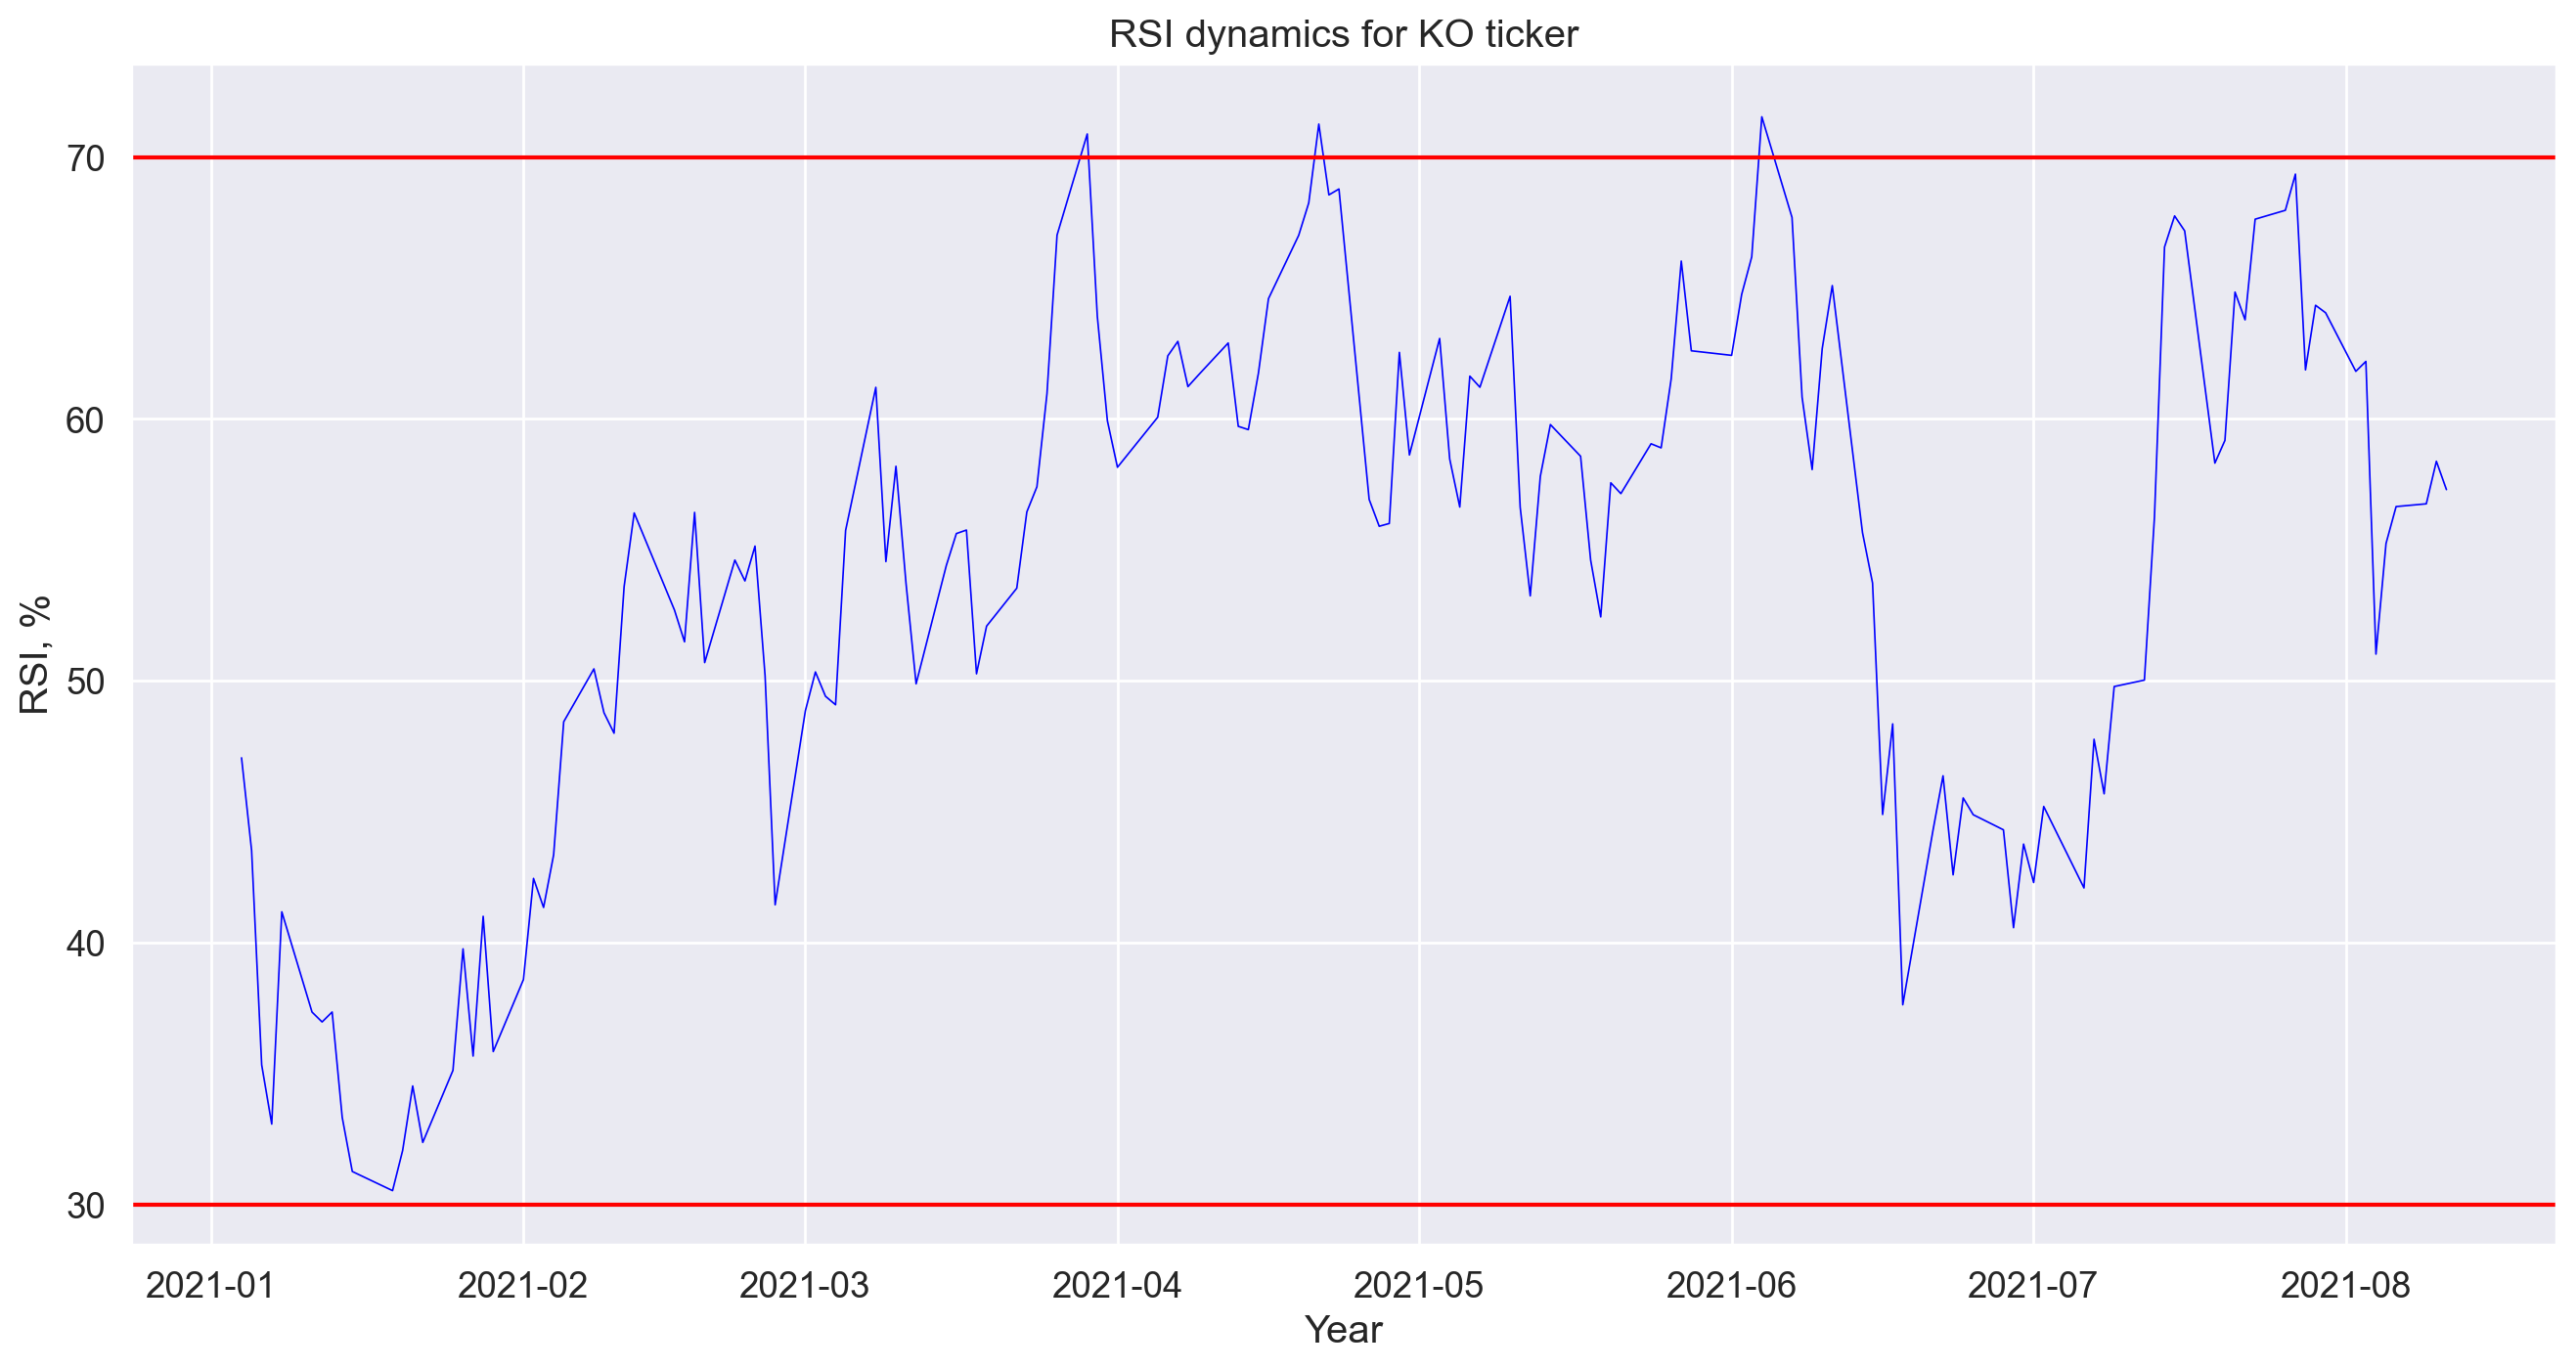

In [29]:
plt.figure(figsize=(16,8), dpi=200)
sns.lineplot(x=df_final.index, y = df_final['momentum_rsi'], color='b', linewidth=0.6)
plt.axhline(y = rsi_oversold, color = 'r', linestyle = '-')
plt.axhline(y = rsi_overbought, color = 'r', linestyle = '-')
plt.title(f"RSI dynamics for {ticker} ticker")
plt.ylabel("RSI, %")
plt.xlabel("Year")
plt.show()

### Number of buy/sold signal given by RSI.

In [30]:
rsi_final_signal = 1 * (df_final['momentum_rsi'] < rsi_oversold) - 1 * (df_final['momentum_rsi'] > rsi_overbought)
num_rsi_signals = rsi_final_signal.value_counts()
print(f'Cash:  {num_rsi_signals[0]} days')
print(f'Short: {num_rsi_signals[-1]} days')

Cash:  150 days
Short: 3 days


### Calculating of RSI strategy outcomes for validation data

In [31]:
rsi_final_return = np.array(df_final['return'][1:]) * rsi_final_signal[:-1]

rsi_final_profit = np.prod(1 + rsi_final_return)

rsi_final_risk = np.std(rsi_final_return) * 252 ** 0.5 * 100

rsi_final_profit_drop_ratio = rsi_final_profit / max_dropdown(rsi_final_return)

rsi_final_sharpe = sharpe_ratio(rsi_final_return)


print(f"RSI total profit:              {rsi_final_profit * 100:.2f}%")
print(f'RSI risk:                      {rsi_final_risk:.2f}%')
print(f'RSI Sharpe ratio :             {rsi_final_sharpe:.2f}')
print(f'RSI acc.profit/ MaxDropDown :  {rsi_final_profit_drop_ratio:.2f}')

RSI total profit:              101.98%
RSI risk:                      1.77%
RSI Sharpe ratio :             95.43
RSI acc.profit/ MaxDropDown :  1.02


---

# 3. Time series forecasting using Long short-term memory (LSTM) network

### $X$ and $y$ split

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
X_train = df_train.drop(['Open', 'High', 'Low', 'Close', 'Adj Close'], axis = 1)
X_test = df_test.drop(['Open', 'High', 'Low', 'Close', 'Adj Close'], axis = 1)

y_train = df_train.Close
y_test = df_test.Close

###  Data scaling
Here we fit scaler only on the train dataset, and not the entire dataset to prevent information leak

In [34]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2445, 83) (2445, 1) (253, 83) (253, 1)


### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [35]:
def create_dataset(X, y, n_past):
    X_set, y_set = [], []
    for i in range(n_past, len(X)):
        X_set.append(X[i - n_past : i, : X.shape[1]])
        y_set.append(y[i])  # predict next record
    return X_set, y_set

In [36]:
n_past = 30

In [37]:
Xtrain, ytrain = create_dataset(X_train, y_train, n_past = n_past)
Xtest, ytest = create_dataset(X_test, y_test, n_past = n_past)

### Descriptor vector reshaping

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [38]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [39]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2415, 30, 83)
(2415, 1)
---
(223, 30, 83)
(223, 1)


In [40]:
!pip install keras
!pip install tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
tf.random.set_seed(1000-7)

You should consider upgrading via the '/Users/dmitry.volkov/.pyenv/versions/3.8.6/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dmitry.volkov/.pyenv/versions/3.8.6/bin/python3.8 -m pip install --upgrade pip' command.


### Model architecture
1. LSTM with `200` neurons in the first visible layer
2. `1` neuron in the output layer for predicting close price.
3. The input shape will be `30` time step with `83` features.
4. Mean Absolute Error (MAE) used as a loss function and the efficient `Adam` version of stochastic gradient descent.
5. The model will be fit for `20` training epochs with a batch size of `70`.

In [41]:
model = Sequential()
model.add(LSTM(200, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    Xtrain, ytrain, epochs=20, validation_data=(Xtest, ytest), batch_size=70, verbose=1
)

2021-10-28 17:07:57.393590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 17:07:58.262475: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
35/35 [==============================] - 6s 94ms/step - loss: 0.0523 - val_loss: 0.0047
Epoch 2/20
35/35 [==============================] - 3s 99ms/step - loss: 9.8696e-04 - val_loss: 0.0042
Epoch 3/20
35/35 [==============================] - 3s 76ms/step - loss: 4.9488e-04 - val_loss: 0.0043
Epoch 4/20
35/35 [==============================] - 3s 99ms/step - loss: 4.1019e-04 - val_loss: 0.0041
Epoch 5/20
35/35 [==============================] - 3s 87ms/step - loss: 3.6047e-04 - val_loss: 0.0042
Epoch 6/20
35/35 [==============================] - 4s 104ms/step - loss: 3.1076e-04 - val_loss: 0.0040
Epoch 7/20
35/35 [==============================] - 4s 106ms/step - loss: 2.8073e-04 - val_loss: 0.0040
Epoch 8/20
35/35 [==============================] - 4s 108ms/step - loss: 2.5746e-04 - val_loss: 0.0040
Epoch 9/20
35/35 [==============================] - 3s 96ms/step - loss: 2.5170e-04 - val_loss: 0.0041
Epoch 10/20
35/35 [==============================] - 4s 106ms/step - loss:

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               227200    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 227,401
Trainable params: 227,401
Non-trainable params: 0
_________________________________________________________________


In [43]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

# invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
testPredict = y_scaler.inverse_transform(testPredict)

trainPredict = [x[0] for x in trainPredict]
testPredict = [x[0] for x in testPredict]

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_real = y_scaler.inverse_transform(y_train[n_past: ])
train_mse = mean_squared_error(y_train_real, trainPredict, squared=True)
train_rmse = mean_squared_error(y_train_real, trainPredict, squared=False)
train_r2 = r2_score(y_train_real, trainPredict)
# calculate root mean squared error
test_mse = mean_squared_error(df.Close[n_past - len(y_test) :], testPredict, squared=True)
test_rmse = mean_squared_error(df.Close[n_past - len(y_test) :], testPredict, squared=False)
test_r2 = r2_score(df.Close[n_past - len(y_test) :], testPredict)


print('Train scores:')
print(f'R2   :  {train_r2:.2f}')
print(f"MSE  :  {train_mse:.2f} ")
print(f"RMSE :  {train_rmse:.2f} \n")


print('Test scores:')
print(f'R2   :  {r2_score(df.Close[n_past - len(y_test) :], testPredict):.2f}')
print(f"MSE  :  {test_mse:.2f} ")
print(f"RMSE :  {test_rmse:.2f} ")

Train scores:
R2   :  1.00
MSE  :  0.17 
RMSE :  0.41 

Test scores:
R2   :  0.72
MSE  :  4.38 
RMSE :  2.09 


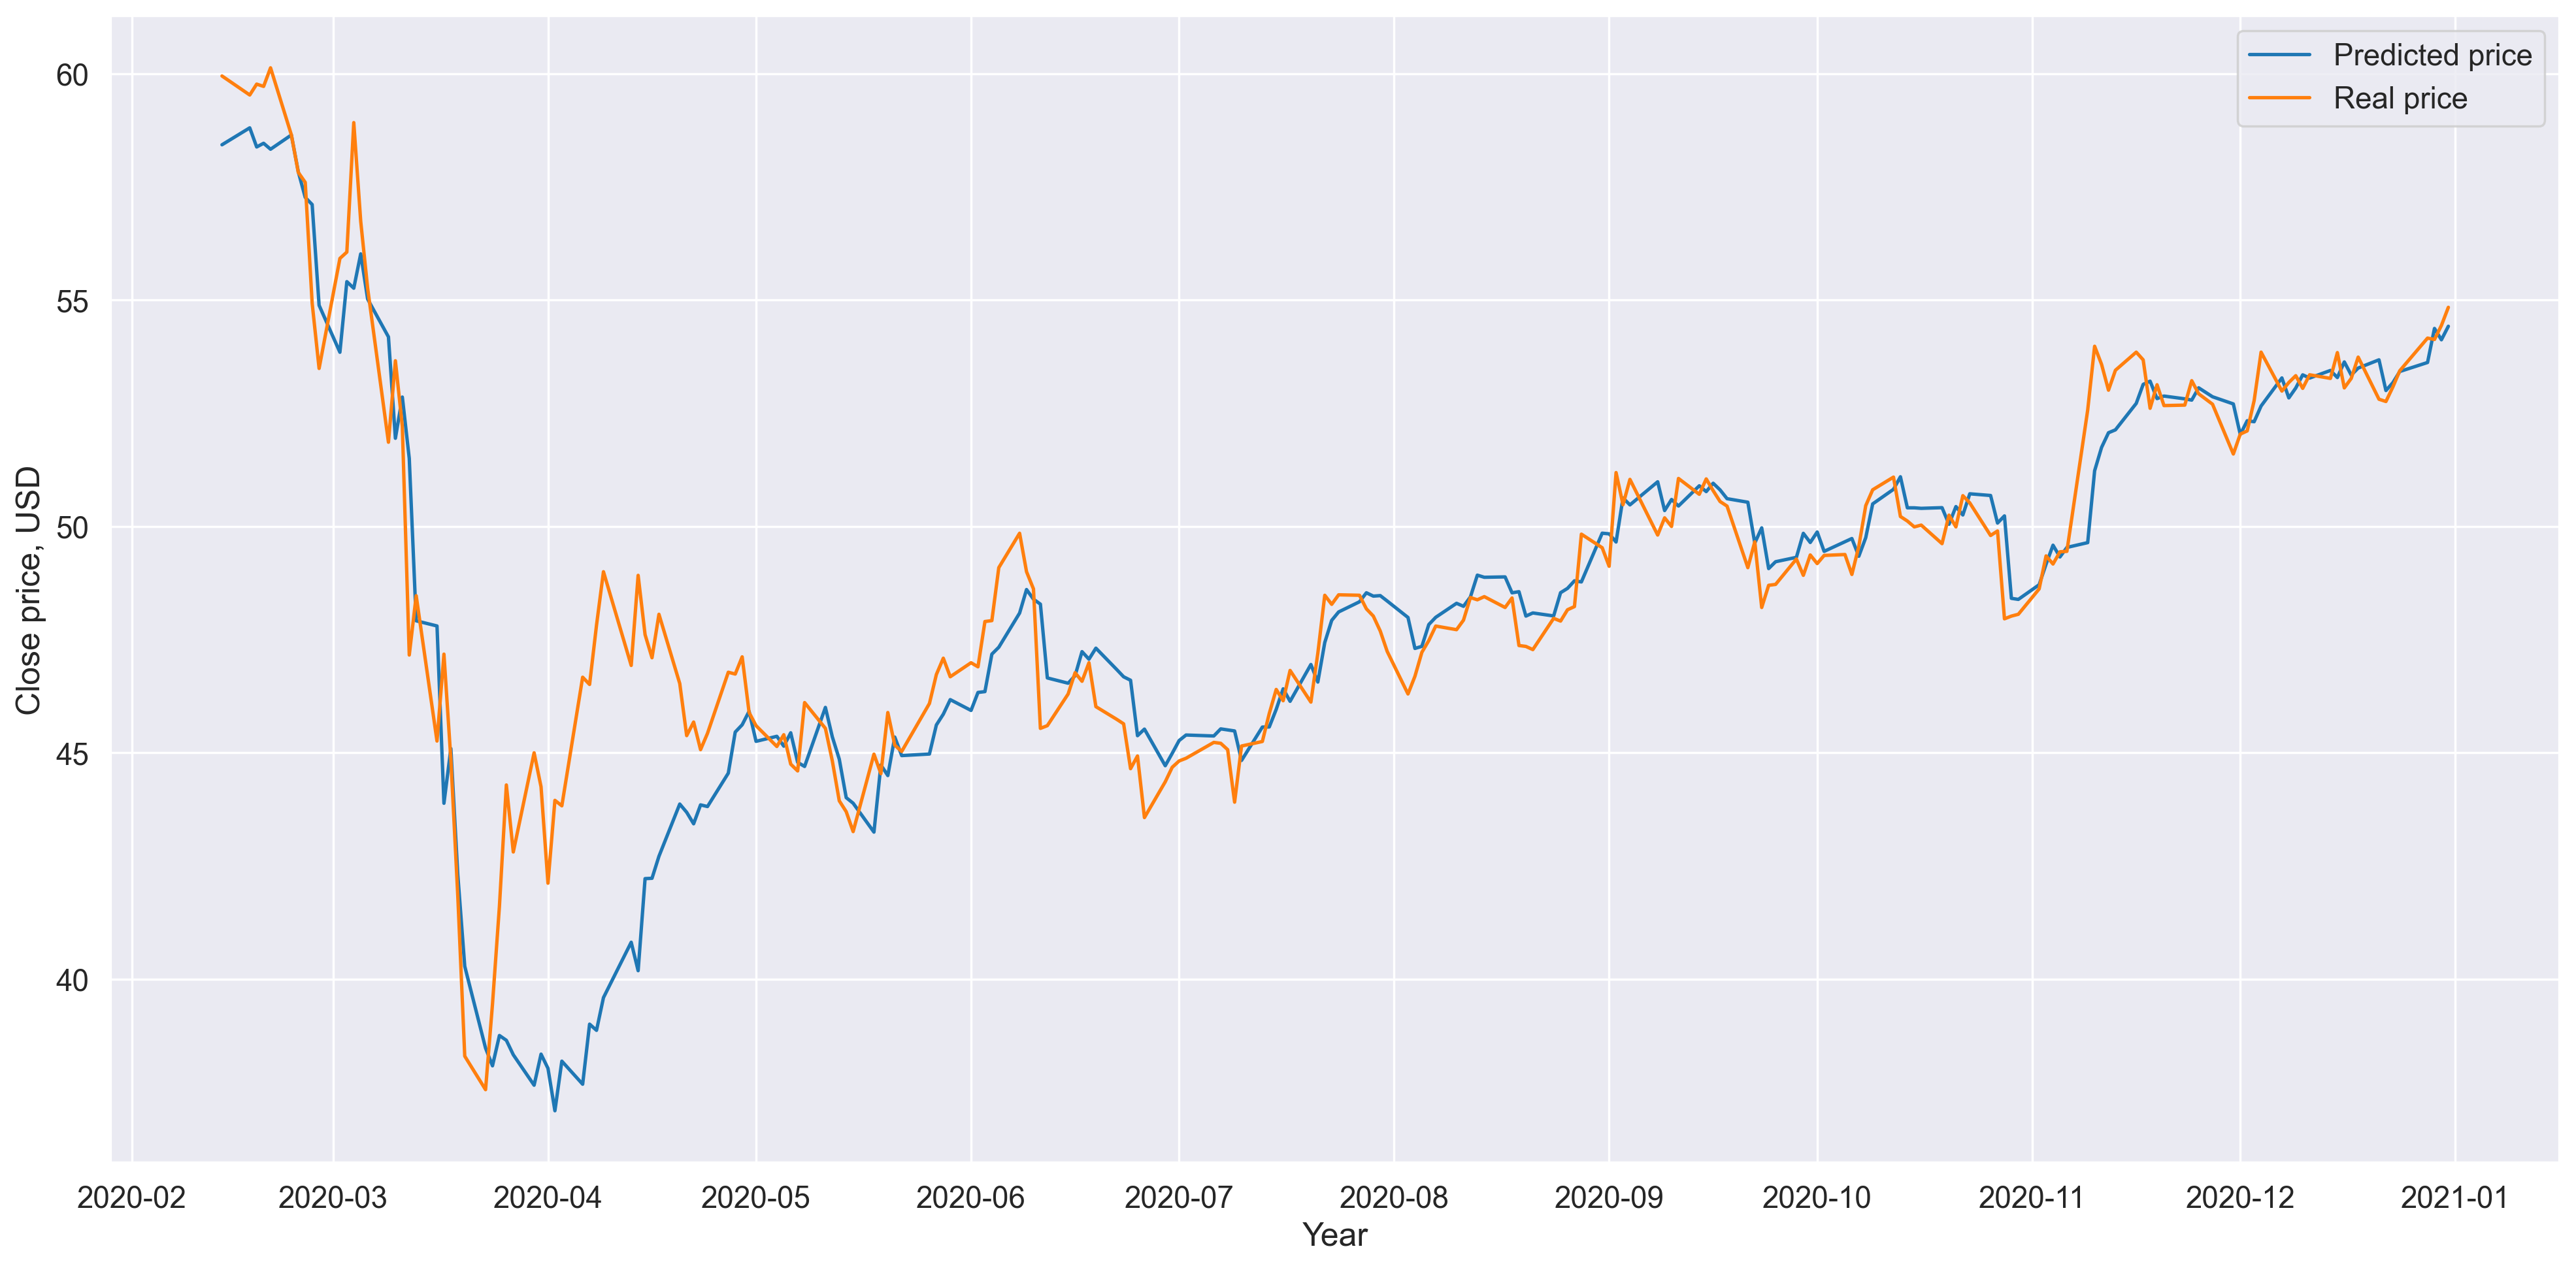

In [45]:
plt.figure(figsize=(16, 8), dpi=250)
sns.lineplot(x = df.index[n_past - len(y_test) :], y = testPredict, label='Predicted price')
sns.lineplot(x = df.index[n_past - len(y_test) :], y = df.Close[n_past - len(y_test) :], label='Real price')
plt.xlabel('Year')
plt.ylabel('Close price, USD')
plt.tight_layout()
# plt.savefig('report/fig/nn.jpg')
plt.show()

### Building traiding strategy

In this case we will use the simple decision making stratagy based on the values predicted for the upcoming date.
If our algorithm predicts that value tomorrow will be larger than today's closing price we suppose that next morning our first order will be `buy (1)` open long position. If the algorithm predicts that price tomorrow will be lower our first order for the next day will be `sell (-1)` i.e. open short position.

In [46]:
df_lstm = df[n_past - len(y_test) : ]

lstm_signal = 1 * (testPredict > df_lstm['Close']) - 1 * (testPredict < df_lstm['Close'])

In [47]:
num_of_signals = lstm_signal.value_counts()
print(f'Long:  {num_of_signals[1]} days')
print(f'Short: {num_of_signals[-1]} days')

Long:  119 days
Short: 104 days


In [48]:
lstm_return = np.array(df_lstm['return'][1:]) * np.array(lstm_signal[:-1])
lstm_profit = np.prod(1 + lstm_return)  * 100
lstm_risk = np.std(lstm_return) * 252 ** 0.5 * 100
lstm_sharpe = sharpe_ratio(lstm_return)
lstm_profit_drop_ratio = lstm_profit / max_dropdown(lstm_return)

In [49]:
print('LSTM strategy results:')
print(f'Total profit           :  {lstm_profit:.2f}%')
print(f'Risk                   :  {lstm_risk:.2f}%')
print(f'Acc.profit/MaxDropDown :  {lstm_profit_drop_ratio:.2f}')

LSTM strategy results:
Total profit           :  157.94%
Risk                   :  36.30%
Acc.profit/MaxDropDown :  61.40


$$x^2$#